# Part I: Replicating Models from Class

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
from math import e
from scipy.optimize import minimize
from scipy.stats import poisson
from scipy.special import gamma
from scipy.special import gammaln
from scipy.special import factorial

### Question 1: Consider the example related to billboard exposures from class. The associated data is in the file billboard.csv. Write code to estimate the parameters of the Poisson model using maximum likelihood estimation (MLE). Report your code, the estimated parameters and the maximum value of the log-likelihood. Predict the number of people with 0, …, 23 exposures based on the Poisson model. Explain how the predicted values are obtained using the case of 2 exposures (show your calculations). Graph the original and predicted number of exposures (number of people on the y-axis and the number of exposures on the x-axis) 

In [2]:
# Reading the dataset
bb_exp = pd.read_csv('/Users/ramyavissapragada/Desktop/buan6383/billboard.csv')
bb_exp

,EXPOSURES,PEOPLE
0,0,48
1,1,37
2,2,30
3,3,24
4,4,20
5,5,16
6,6,13
7,7,11
8,8,9
9,9,7


In [3]:
# Defining the log-likelihood function
def LL_p(params, e, p):
    l = params
    prob = []
    ll = []
    
    for i in range(len(e)):
        if i == 0:
            prob.append(math.exp(-l))
        else:
            prob.append(((l**i)*(math.exp(-l)))/math.factorial(i))
        ll.append(p[i] * math.log(prob[i]))
    return ll

In [4]:
# Defining the negative log-likelihood function
def NLL_p(params, e, p):
    return(-np.sum(LL_p(params, e, p)))

In [5]:
# Setting up the parameters
params = np.array((0.5))
e = np.array(bb_exp.EXPOSURES)
p = np.array(bb_exp.PEOPLE)

In [6]:
# Minimizing the negative log likelihood function
soln_p = minimize(
    NLL_p,
    args = (e, p),
    x0 = params,
    bounds = [(0.000001, None)],
    tol = 1e-10,
    options = {'ftol' : 1e-8}
)

In [7]:
# Printing the solution
soln_p

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 929.0438827273031
        x: [ 4.456e+00]
      nit: 9
      jac: [-3.411e-05]
     nfev: 20
     njev: 10
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [8]:
# Looking at the optimal value of lambda (l)
l1 = soln_p.x[0]
l1

4.4559993693051325

In [9]:
# Maximum value of log-likelihood 
ll_poi = -soln_p.fun
ll_poi

-929.0438827273031

In [10]:
# Predicting the number of people given exposure for the week data we have.
def predict_p(op_l, e, people):
    predP = []
    for i in range(len(e)):
        pred = ((math.exp(-op_l) * (op_l ** i)) / math.factorial(i)) * people
        predP.append(pred)
    return predP

In [11]:
# Printing the predicted values
preds = predict_p(l1, e, np.sum(p))

In [12]:
# Calculate for 2 exposures
e2 = bb_exp.EXPOSURES[2]
p2 = bb_exp.PEOPLE[2]
pred2 = (math.exp(-l1) * (l1 ** e2)) / math.factorial(e2) * 250
pred2

28.812723857097705

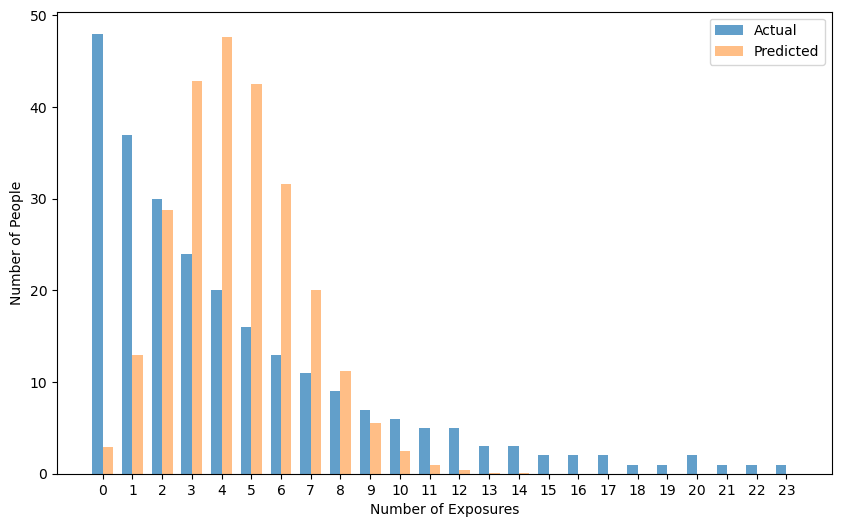

In [13]:
# Plotting the actual vs the predicted data.
bar_width = 0.35
x = range(len(e))

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], p, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], preds, bar_width, alpha=0.5, label="Predicted", color="tab:orange")
plt.xlabel("Number of Exposures")
plt.ylabel("Number of People")
plt.xticks(x, e)
plt.legend()
plt.show()

### Question 2: Next, write code (for the same dataset) to estimate the parameters of the NBD model using MLE. Report your code, the estimated parameters and the maximum value of the log-likelihood. Evaluate the NBD model vis-à-vis the Poisson model; explain which is better and why. Predict the number of people with 0, …, 23 exposures based on the NBD model. Explain how the predicted values are obtained using the case of 2 exposures (show your calculations). Graph the original and predicted numbers of exposures. 

In [14]:
# Defining the recursive function for k > 0
def nbd(k, n, a, pmf_k_minus_1):
    return (n + k - 1) / (k * (a + 1)) * pmf_k_minus_1

In [15]:
# Defining the log-likelihood function
def LL_nbd(params, e, people):
    n, a = params
    pmf = np.zeros(len(e))
    pmf[0] = (a / (a + 1)) ** n
    ll_nbd = people[0] * np.log(pmf[0])
    
    for k in range(1, len(e)):
        pmf[k] = nbd(k, n, a, pmf[k - 1])
        ll_nbd += people[k] * np.log(pmf[k])
    
    return -ll_nbd

In [16]:
# Passing the parameters
params = np.array([1.0, 0.5])
exposures = np.array(bb_exp.EXPOSURES)
people = np.array(bb_exp.PEOPLE)

In [17]:
# Minimizing the negative log-likelihood value as returend by the LL() function.
soln_nbd = minimize(
    LL_nbd,
    args=(exposures, people),
    x0=params,
    bounds=[(0.000001, None), (0.000001, None)],  # 'r' and 'a' should be >= 0
    tol=1e-10,
    options={'ftol': 1e-8}
)

In [18]:
# Printing the optimal n and a values
optimal_n, optimal_a = soln_nbd.x
print(f"Optimal n: {optimal_n}")
print(f"Optimal a: {optimal_a}")

Optimal n: 0.9692642014951004
Optimal a: 0.21752139825750305


In [19]:
# Maximum value of log-likelihood 
ll_nbd = -soln_nbd.fun
ll_nbd

-649.6888274977052

In [20]:
# Predicting number of people against number of exposures using the NBD Model.
def predict_nbd(params, e, total_people):
    n, a = params
    predictions = np.zeros(len(e))
    predictions[0] = (a / (a + 1)) ** n
    
    for k in range(1, len(e)):
        predictions[k] = nbd(k, n, a, predictions[k - 1])
    
    # Scale the predictions to the total number of people
    scaled_predictions = predictions * total_people
    
    return scaled_predictions

# Total numbe of people in the dataset
total_people = np.sum(people)

# Use the fitted parameters to make predictions and scale them to total people
optimal_params = (optimal_n, optimal_a)
predicted_people = predict_nbd(optimal_params, exposures, total_people)

In [21]:
# Looking into the predicted people.
predicted_people

array([47.09285164, 37.49044189, 30.31921461, 24.6472762 , 20.08826112,
       16.39788459, 13.39925875, 10.95703527,  8.96488442,  7.33807928,
        6.00853925,  4.92126908,  4.03168614,  3.30355923,  2.70739106,
        2.21913428,  1.81916421,  1.49145238,  1.22289896,  1.002792  ,
        0.82236823,  0.67445599,  0.5531843 ,  0.45374567])

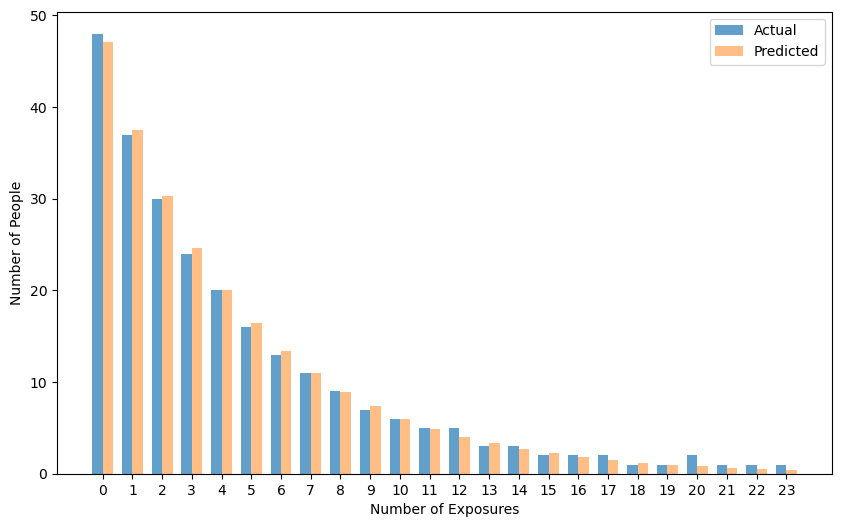

In [22]:
# Plotting the actual and predicted histograms.

bar_width = 0.35
x = range(len(exposures))

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], people, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], predicted_people, bar_width, alpha=0.5, label="Predicted", color="tab:orange")
plt.xlabel("Number of Exposures")
plt.ylabel("Number of People")
plt.xticks(x, exposures)
plt.legend()
plt.show()

### Question 3: Now consider the khakichinos example from class; The associated data is in the file khakichinos.csv. Estimate all relevant parameters for Poisson regression using MLE. Report your code, the estimated parameters and the maximum value of the log-likelihood. Predict the number of people with 0, …, 23 exposures based on the Poisson regression. Explain how the predicted values are obtained using the case of 2 exposures (show your calculations). Graph the original and predicted numbers of exposures. 

In [23]:
# Reading the dataset.
kch = pd.read_csv('/Users/ramyavissapragada/Desktop/buan6383/khakichinos.csv')
kch

,ID,NumberofVisits,LnInc,Sex,LnAge,HHSize
0,1,0,11.379394,1,3.871201,2
1,2,5,9.769956,1,4.043051,1
2,3,0,11.082143,0,3.332205,2
3,4,0,10.915088,1,3.951244,3
4,5,0,10.915088,1,2.833213,3
...,...,...,...,...,...,...
2723,2724,0,9.528794,1,2.944439,2
2724,2725,0,11.379394,0,3.970292,2
2725,2726,0,11.191342,1,3.044522,3
2726,2727,0,10.532096,1,2.890372,4


In [24]:
# Defining the log-likelihood function
def LL_pr(params, v, x1, x2, x3, x4):
    l0, b1, b2, b3, b4 = params
    li = []
    for i in range(len(v)):
        li.append(l0*np.exp(b1*x1[i] + b2*x2[i] + b3*x3[i] + b4*x4[i]))
       
    #prob_pr = []
    ll = []
    
    for i in range(len(v)):
            ll_1 = v[i]*np.log(li[i])
            ll_2 = (li[i])
            ll_3a = np.math.factorial(v[i])
            ll_3 = np.log(float(ll_3a))
            ll.append(ll_1-ll_2-ll_3)

    return ll


In [25]:
# Defining the negative log-likelihood function
def NLL_pr(params, v, x1, x2, x3, x4):
    return(-np.sum(LL_pr(params, v, x1, x2, x3, x4)))

In [26]:
# Setting up the parameters
params = np.array([0.5, 0.1, 0.2, 0.5, -0.3])
v = np.array(kch.NumberofVisits)
x1 = np.array(kch.LnInc)
x2 = np.array(kch.Sex)
x3 = np.array(kch.LnAge)
x4 = np.array(kch.HHSize)

In [27]:
# Minimizing the Negative Log-Likelihood of the model established.
soln_pr = minimize(
    NLL_pr, 
    args=(v, x1, x2, x3, x4),
    x0=np.array((1,0.2,0.3,0.1,-0.3)),
    bounds=[(0.00000001,None),(None,None),(None,None),(None,None),(None,None)],
    tol=1e-10,
    options={'ftol':1e-8}
)

In [28]:
# Looking into the solution. 
soln_pr

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 6291.496747493691
        x: [ 4.389e-02  9.383e-02  4.268e-03  5.882e-01 -3.590e-02]
      nit: 82
      jac: [-1.389e-01 -6.221e-02  4.729e-03 -4.547e-02  5.384e-02]
     nfev: 630
     njev: 105
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

In [29]:
# Printing the optimal parameters
optimal_l0, optimal_b1, optimal_b2, optimal_b3, optimal_b4 = soln_pr.x
print(f"Optimal l0: {optimal_l0}")
print(f"Optimal b1: {optimal_b1}")
print(f"Optimal b2: {optimal_b2}")
print(f"Optimal b3: {optimal_b3}")
print(f"Optimal b4: {optimal_b4}")

Optimal l0: 0.04388559117134688
Optimal b1: 0.09383433292308603
Optimal b2: 0.004267656996633129
Optimal b3: 0.5882009941783403
Optimal b4: -0.035896514680631444


In [30]:
# Maximum value of log-likelihood 
ll_pr = -soln_pr.fun
ll_pr

-6291.496747493691

In [31]:
# Predicting number of people aginst number of visits using the Poisson Regression
def pred_pr(v, x1, x2, x3, x4):
    predPr = []
    li = []
    for i in range(len(v)):
        li.append(optimal_l0*np.exp(optimal_b1*x1[i] + optimal_b2*x2[i] + optimal_b3*x3[i] + optimal_b4*x4[i]))
        
    for j in range(len(v)):
        pred = ((math.exp(-li[j]) * (li[j] ** v[j])) / math.factorial(v[j]))
        predPr.append(pred)
    return predPr


In [32]:
# Setting up the parameters
v = np.array(kch.NumberofVisits)
x1 = np.array(kch.LnInc)
x2 = np.array(kch.Sex)
x3 = np.array(kch.LnAge)
x4 = np.array(kch.HHSize)

In [33]:
# getting the predicted values.
preds = pred_pr(v, x1, x2, x3, x4)

In [34]:
# Setting up the dataset for easy calculation of predictions and also for plotting the graph.
pred_kch = kch.copy()
pred_kch

,ID,NumberofVisits,LnInc,Sex,LnAge,HHSize
0,1,0,11.379394,1,3.871201,2
1,2,5,9.769956,1,4.043051,1
2,3,0,11.082143,0,3.332205,2
3,4,0,10.915088,1,3.951244,3
4,5,0,10.915088,1,2.833213,3
...,...,...,...,...,...,...
2723,2724,0,9.528794,1,2.944439,2
2724,2725,0,11.379394,0,3.970292,2
2725,2726,0,11.191342,1,3.044522,3
2726,2727,0,10.532096,1,2.890372,4


In [35]:
# Creating a Pandas Series from the list `preds`.
preds_series = pd.Series(preds, name='preds')

# Inserting the Pandas Series into the DataFrame `pred_kch` as a new column.
pred_kch.insert(loc=len(pred_kch.columns), column='preds', value=preds_series)


In [36]:
# Setting up the dataset for easy calculation of predictions and also for plotting the graph.
pred_kch

,ID,NumberofVisits,LnInc,Sex,LnAge,HHSize,preds
0,1,0,11.379394,1,3.871201,2,0.312502
1,2,5,9.769956,1,4.043051,1,0.005253
2,3,0,11.082143,0,3.332205,2,0.440294
3,4,0,10.915088,1,3.951244,3,0.324301
4,5,0,10.915088,1,2.833213,3,0.557998
...,...,...,...,...,...,...,...
2723,2724,0,9.528794,1,2.944439,2,0.567305
2724,2725,0,11.379394,0,3.970292,2,0.292965
2725,2726,0,11.191342,1,3.044522,3,0.507652
2726,2727,0,10.532096,1,2.890372,4,0.570338


In [37]:
# Getting the unique visit counts
unique_visits = np.unique(pred_kch['NumberofVisits'])

# Initializing a dictionary to store the results
results_by_visit = {}

# Looping through each unique visit count
for visit_count in unique_visits:
    indices = np.where(pred_kch['NumberofVisits'] == visit_count)[0]
    pred_sum = pred_kch.loc[indices, 'preds'].sum()
    results_by_visit[visit_count] = {'pred_sum': pred_sum, 'num_indices': len(indices)}

# Printing the results.
for visit_count, result in results_by_visit.items():
    print(f"Visits: {visit_count}, Predicted Sum: {result['pred_sum']}, Number of People: {result['num_indices']}")


Visits: 0, Predicted Sum: 832.0143578817579, Number of People: 2046
Visits: 1, Predicted Sum: 113.35645653042482, Number of People: 318
Visits: 2, Predicted Sum: 23.873345632843236, Number of People: 129
Visits: 3, Predicted Sum: 4.244406024470581, Number of People: 66
Visits: 4, Predicted Sum: 0.6539724817492016, Number of People: 38
Visits: 5, Predicted Sum: 0.13612657428791108, Number of People: 30
Visits: 6, Predicted Sum: 0.012189709817996493, Number of People: 16
Visits: 7, Predicted Sum: 0.0021328868894394384, Number of People: 11
Visits: 8, Predicted Sum: 0.00022254262199630738, Number of People: 9
Visits: 9, Predicted Sum: 3.222956452173987e-05, Number of People: 10
Visits: 10, Predicted Sum: 8.376687100641824e-07, Number of People: 5
Visits: 11, Predicted Sum: 6.973362891728302e-07, Number of People: 6
Visits: 12, Predicted Sum: 6.993606751483782e-09, Number of People: 5
Visits: 14, Predicted Sum: 6.221823397817419e-11, Number of People: 4
Visits: 15, Predicted Sum: 9.2974385

In [38]:
# Setting up the values to plot the graph, from the above information.
# Note: The values after 10 visits are very small so to plot the graphs, we will combine the result as 10+ visits.
num_people=[2046, 318, 129, 66, 38, 30, 16, 11, 9, 10, 55]

In [39]:
# Initializing an array to store the calculated values
calculated_values = np.zeros(len(results_by_visit))

# Looping through each unique visit count
for i, (visit_count, result) in enumerate(results_by_visit.items()):
    calculated_values[i] = (result['pred_sum'] / result['num_indices']) * 2728

In [40]:
# Getting the sum of probabilities for 10+ visits.
sum_10_plus = np.sum(calculated_values[10:])
sum_10_plus

0.0007779550734940618

In [41]:
# Converting the predicted values into integers for the purpose of plotting the graph.
predicted_people = [1.10935248e+003, 9.72441552e+002, 5.04856487e+002, 1.75435449e+002, 4.69483403e+001, 1.23784432e+001, 2.07834552e+000, 5.28955949e-001, 6.74551414e-002, 8.79222520e-003, 0.0007779550734940618]
predicted_people = [int(x) for x in predicted_people]
predicted_people

[1109, 972, 504, 175, 46, 12, 2, 0, 0, 0, 0]

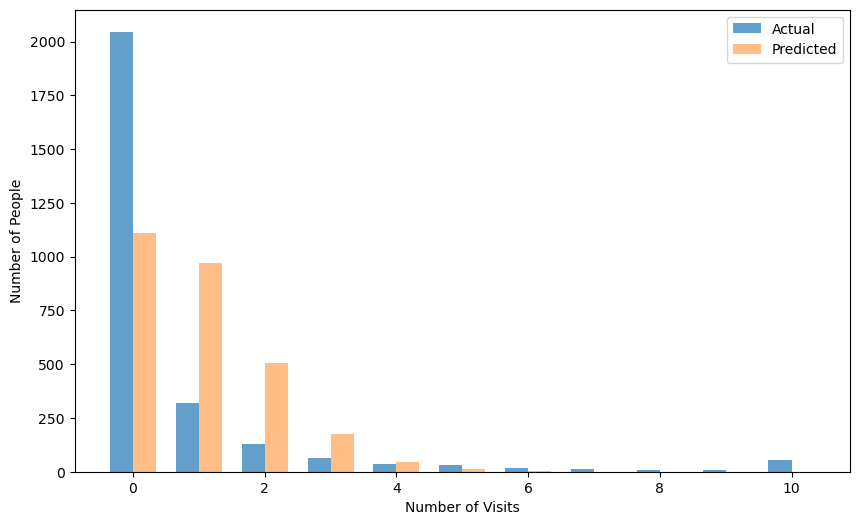

In [42]:
# Plotting the actual vs the predicted data.
bar_width = 0.35
x = range(0, 11)

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], num_people, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], predicted_people, bar_width, alpha=0.5, label="Predicted", color="tab:orange")
plt.xlabel("Number of Visits")
plt.ylabel("Number of People")

plt.legend()
plt.show()

### Question 4:  The NBD Regression: Consider the khakichinos example again. Estimate all relevant parameters for NBD regression using MLE. Report your code, the estimated parameters and the maximum value of the log-likelihood. Evaluate the NBD regression vis-à-vis the Poisson regression; explain which is better and why. Predict the number of people with 0, …, 23 exposures based on the NBD regression. Explain how the predicted values are obtained using the case of 2 exposures (show your calculations). Graph the original and predicted numbers of exposures.

In [43]:
# Setting up the parameters.
v = np.array(kch['NumberofVisits'])
x1= np.array(kch['LnInc'])
x2= np.array(kch['Sex'])
x3= np.array(kch['LnAge'])
x4= np.array(kch['HHSize'])

In [44]:
# Defining the NBD-regression Log Likelihood fucntion
def LL_nbdr(params,x1,x2,x3,x4,v):
    n,alpha,nbeta1, nbeta2, nbeta3, nbeta4= params
    nll=0
    nll1=0
    nll2=0
    nll3=0
    nll4=0
    for i in range(len(x1)):
        beta=math.exp(nbeta1*x1[i]+nbeta2*x2[i]+nbeta3*x3[i]+nbeta4*x4[i])
        nll1=nll1+np.log(math.gamma(n+int(v[i])))
        nll2=nll2+np.log(math.gamma(n))+np.log(factorial(int(v[i])))
        nll3=nll3+n*(np.log(alpha)-np.log(alpha+beta))
        nll4=nll4+int(v[i])*(np.log(beta)-np.log(alpha+beta))
    nll=nll1-nll2+nll3+nll4
    return nll*(-1)
    

In [45]:
# Getting the optimal values 
soln_nbdr = minimize(LL_nbdr,  args=(x1,x2,x3,x4,v),x0=np.array((1,1,0.2,0.3,0.1,-0.3)),bounds=[(0.00000001,None),(0.00000001,None),(None,None),(None,None),(None,None),(None,None)],tol=1e-10,options={'ftol':1e-8})
n = soln_nbdr.x[0]
alpha = soln_nbdr.x[1]
beta1 = soln_nbdr.x[2]
beta2 = soln_nbdr.x[3]
beta3 = soln_nbdr.x[4]
beta4 = soln_nbdr.x[5]

In [46]:
# Getting the optimal values
nll=0
nll1=0
nll2=0
nll3=0
nll4=0

for i in range(len(x1)):
    beta=math.exp(beta1*x1[i]+beta2*x2[i]+beta3*x3[i]+beta4*x4[i])
    nll1=nll1+np.log(math.gamma(n+int(v[i])))
    nll2=nll2+np.log(math.gamma(n))+np.log(factorial(int(v[i])))
    nll3=nll3+n*(np.log(alpha)-np.log(alpha+beta))
    nll4=nll4+int(v[i])*(np.log(beta)-np.log(alpha+beta))
nll=nll1-nll2+nll3+nll4

In [47]:
# Looking into the solution
soln_nbdr

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2888.966117052838
        x: [ 1.388e-01  8.177e+00  7.321e-02 -9.275e-03  9.021e-01
            -2.436e-02]
      nit: 81
      jac: [ 3.083e-02 -1.364e-04 -2.456e-02 -1.273e-03 -5.184e-03
            -2.879e-02]
     nfev: 672
     njev: 96
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [48]:
# Printing out the optimal parameters.
optimal_n, optimal_a, optimal_b1, optimal_b2, optimal_b3, optimal_b4 = soln_nbdr.x
print(f"Optimal n: {optimal_n}")
print(f"Optimal a: {optimal_a}")
print(f"Optimal b1: {optimal_b1}")
print(f"Optimal b2: {optimal_b2}")
print(f"Optimal b3: {optimal_b3}")
print(f"Optimal b4: {optimal_b4}")

Optimal n: 0.13875193522417364
Optimal a: 8.176710031415167
Optimal b1: 0.07321150220946064
Optimal b2: -0.00927489555886401
Optimal b3: 0.9020673215315569
Optimal b4: -0.02435922197887667


In [49]:
# Pritnting the maximum value of the Log-likelihood.
nbdr_mll = soln_nbdr.fun
-nbdr_mll

-2888.966117052838

In [50]:
# Setting up the predict function
def predict_nbdr(v, x1, x2, x3, x4):
    predPr = []
    b = []
    for i in range(len(v)):  # This iterates over all elements in the input arrays
        b.append(math.exp(optimal_b1 * x1[i] + optimal_b2 * x2[i] + optimal_b3 * x3[i] + optimal_b4 * x4[i]))

    for j in range(len(v)):
        p_1 = (math.gamma(optimal_n + v[j])) / (math.gamma(optimal_n) * math.factorial(v[j]))
        p_2 = (optimal_a / (optimal_a + b[j])) ** optimal_n
        p_3 = (b[j] / (optimal_a + b[j])) ** v[j]
        pred = p_1 * p_2 * p_3
        predPr.append(pred)

    return predPr

    

In [51]:
# Setting up the parameters
v = np.array(kch.NumberofVisits)
x1 = np.array(kch.LnInc)
x2 = np.array(kch.Sex)
x3 = np.array(kch.LnAge)
x4 = np.array(kch.HHSize)

In [52]:
# Getting the predicted values/probabilities
ans = predict_nbdr(v, x1, x2, x3, x4)

In [53]:
ans

[0.7293635248262396,
 0.015869675466648362,
 0.7746676160039875,
 0.728106055041981,
 0.81875181857079,
 0.8091820065761317,
 0.7468016089168071,
 0.09013831501405441,
 0.7045416436234805,
 0.7355476132722844,
 0.09075214983669036,
 0.7219685932402113,
 0.02795519781555154,
 0.7507459506863574,
 0.7628776701693805,
 0.08984244634302574,
 0.04587248641807157,
 0.7260280413676309,
 0.008590820004234709,
 0.7595540069271628,
 0.04256751144016448,
 0.7638688815520418,
 0.7664677215783614,
 0.04625204162127551,
 0.6955287414225988,
 0.7066637462252429,
 0.7693165741322623,
 0.7173793025728948,
 0.7399578632484018,
 0.7621093751636382,
 0.7719195226029908,
 0.8014177727113362,
 0.7771035175249856,
 0.7809410779117884,
 0.764469409958565,
 0.7194353441681138,
 0.04515166169355611,
 0.04589075270658603,
 0.08987572225309218,
 0.8370570488577556,
 0.7388455352220505,
 0.7106693399462151,
 0.7059934121608947,
 0.7697518508842188,
 0.7837631527354435,
 0.770672863051023,
 0.7980378092295616,
 0.7

In [54]:
# Setting up the dataset for easy calculation of predictions and also for plotting the graph.
pred_nr = kch.copy()
pred_nr

,ID,NumberofVisits,LnInc,Sex,LnAge,HHSize
0,1,0,11.379394,1,3.871201,2
1,2,5,9.769956,1,4.043051,1
2,3,0,11.082143,0,3.332205,2
3,4,0,10.915088,1,3.951244,3
4,5,0,10.915088,1,2.833213,3
...,...,...,...,...,...,...
2723,2724,0,9.528794,1,2.944439,2
2724,2725,0,11.379394,0,3.970292,2
2725,2726,0,11.191342,1,3.044522,3
2726,2727,0,10.532096,1,2.890372,4


In [55]:
# Creating a Pandas Series from the list `preds`.
preds_nr_series = pd.Series(ans, name='preds_nbd')

# Inserting the Pandas Series into the DataFrame `pred_kch` as a new column.
pred_nr.insert(loc=len(pred_nr.columns), column='preds_nbd', value=preds_nr_series)


In [56]:
# Setting up the dataset for easy calculation of predictions and also for plotting the graph.
pred_nr

,ID,NumberofVisits,LnInc,Sex,LnAge,HHSize,preds_nbd
0,1,0,11.379394,1,3.871201,2,0.729364
1,2,5,9.769956,1,4.043051,1,0.015870
2,3,0,11.082143,0,3.332205,2,0.774668
3,4,0,10.915088,1,3.951244,3,0.728106
4,5,0,10.915088,1,2.833213,3,0.818752
...,...,...,...,...,...,...,...
2723,2724,0,9.528794,1,2.944439,2,0.816737
2724,2725,0,11.379394,0,3.970292,2,0.720417
2725,2726,0,11.191342,1,3.044522,3,0.800241
2726,2727,0,10.532096,1,2.890372,4,0.818824


In [57]:
# Getting the unique visit counts
unique_visits = np.unique(pred_nr['NumberofVisits'])

# Initializing a dictionary to store the results
results_by_visit = {}

# Looping through each unique visit count
for visit_count in unique_visits:
    indices = np.where(pred_nr['NumberofVisits'] == visit_count)[0]
    pred_sum = pred_nr.loc[indices, 'preds_nbd'].sum()
    results_by_visit[visit_count] = {'pred_sum': pred_sum, 'num_indices': len(indices)}

# Printing the results.
for visit_count, result in results_by_visit.items():
    print(f"Visits: {visit_count}, Predicted Sum: {result['pred_sum']}, Number of People: {result['num_indices']}")


Visits: 0, Predicted Sum: 1552.626824630853, Number of People: 2046
Visits: 1, Predicted Sum: 28.627456155416283, Number of People: 318
Visits: 2, Predicted Sum: 5.812988059089342, Number of People: 129
Visits: 3, Predicted Sum: 1.8680453367077645, Number of People: 66
Visits: 4, Predicted Sum: 0.7455513540545966, Number of People: 38
Visits: 5, Predicted Sum: 0.43933108233060514, Number of People: 30
Visits: 6, Predicted Sum: 0.17461714206402484, Number of People: 16
Visits: 7, Predicted Sum: 0.09932130758162157, Number of People: 11
Visits: 8, Predicted Sum: 0.0574366041474391, Number of People: 9
Visits: 9, Predicted Sum: 0.05189797403096629, Number of People: 10
Visits: 10, Predicted Sum: 0.020200307216325045, Number of People: 5
Visits: 11, Predicted Sum: 0.022707184285903226, Number of People: 6
Visits: 12, Predicted Sum: 0.012396635343624372, Number of People: 5
Visits: 14, Predicted Sum: 0.007819864038582957, Number of People: 4
Visits: 15, Predicted Sum: 0.0048044906993970436,

In [58]:
# Setting up the values to plot the graph, from the above information.
# Note: The values after 10 visits are very small so to plot the graphs, we will combine the result as 10+ visits.
nbdr_people=[2046, 318, 129, 66, 38, 30, 16, 11, 9, 10, 55]

In [59]:
# Initializing an array to store the calculated values
calculated_values_nbdr = np.zeros(len(results_by_visit))

# Looping through each unique visit count
for i, (visit_count, result) in enumerate(results_by_visit.items()):
    calculated_values_nbdr[i] = (result['pred_sum'] / result['num_indices']) * 2728

In [60]:
# Getting the sum of probabilities for 10+ visits.
sum_10_plus_nbdr = np.sum(calculated_values_nbdr[10:])
sum_10_plus_nbdr

53.22625366241662

In [61]:
# Looking into the predicted probabilities
calculated_values_nbdr

array([2.07016910e+03, 2.45583963e+02, 1.22928926e+02, 7.72125406e+01,
       5.35227393e+01, 3.99498398e+01, 2.97722227e+01, 2.46316843e+01,
       1.74096729e+01, 1.41577673e+01, 1.10212876e+01, 1.03241998e+01,
       6.76360424e+00, 5.33314727e+00, 4.36888354e+00, 3.55190220e+00,
       2.54021782e+00, 1.22212421e+00, 1.44890984e+00, 1.53761110e+00,
       7.99480927e-01, 4.15143764e-01, 1.29576852e+00, 9.76559779e-01,
       6.25543137e-01, 2.89022916e-01, 2.54641541e-01, 6.98805607e-02,
       4.90366355e-02, 3.29062842e-01, 1.98570454e-03, 4.95348930e-03,
       3.24780321e-03, 3.84158932e-05])

In [62]:
# Converting the predicted values into integers for easy plotting of the graph
predicted_nreg = [2.07016910e+03, 2.45583963e+02, 1.22928926e+02, 7.72125406e+01,5.35227393e+01, 3.99498398e+01, 2.97722227e+01, 2.46316843e+01,1.74096729e+01, 1.41577673e+01, 53.22625366241662]
predicted_nreg = [int(x) for x in predicted_nreg]
predicted_nreg

[2070, 245, 122, 77, 53, 39, 29, 24, 17, 14, 53]

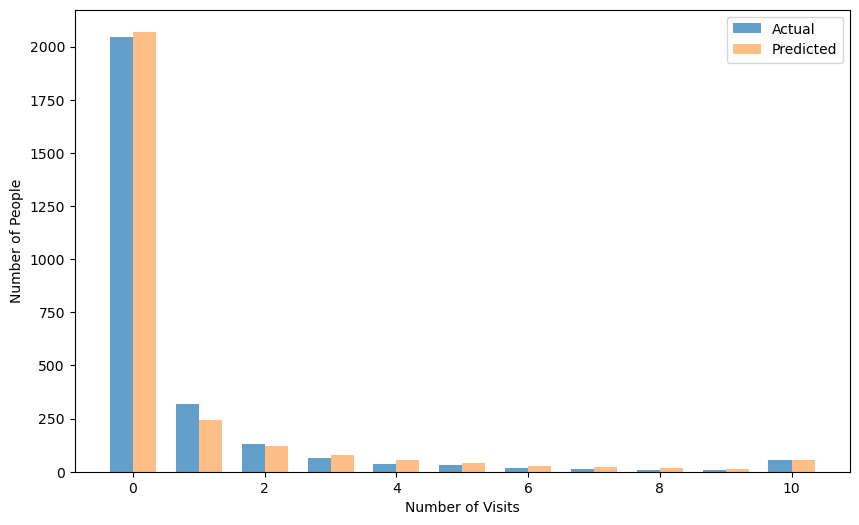

In [63]:
# Plotting the actual vs the predicted data.
bar_width = 0.35
x = range(0, 11)

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], nbdr_people, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], predicted_nreg, bar_width, alpha=0.5, label="Predicted", color="tab:orange")
plt.xlabel("Number of Visits")
plt.ylabel("Number of People")

plt.legend()
plt.show()


# Part II: Analysis of New Data 

### Question 1: Read books.csv and generate two new datasets – (a): books01.csv, with the structure of the dataset used in the billboard exposures example (i.e., with only two columns – (i) the number purchases, and (ii) the number of people making the corresponding number of purchases), and (b): books02.csv, with the structure of the dataset used in the khakichinos example, with a new column containing a count of the number of books purchased from barnesandnoble.com by each customer, while keeping the demographic variables (remember to drop date, product, and price). Print the first and last 10 records of both new datasets.

### 1(a): books01.csv, with the structure of the dataset used in the billboard exposures example (i.e., with only two columns – (i) the number purchases, and (ii) the number of people making the corresponding number of purchases)

In [64]:
# Reading the dataset
books = pd.read_csv('/Users/ramyavissapragada/Desktop/buan6383/books.csv')
books = books.drop(['date', 'product', 'price'], axis = 1)
books

,userid,education,region,hhsz,age,income,child,race,country,domain,qty
0,11443031,4.0,1.0,2,11.0,4,1,1,0,amazon.com,1
1,11443031,4.0,1.0,2,11.0,4,1,1,0,amazon.com,1
2,11443031,4.0,1.0,2,11.0,4,1,1,0,amazon.com,1
3,11519009,NaN,2.0,3,5.0,3,1,2,0,amazon.com,1
4,11519009,NaN,2.0,3,5.0,3,1,2,0,amazon.com,1
...,...,...,...,...,...,...,...,...,...,...,...
40940,15557019,NaN,2.0,3,6.0,6,1,1,0,amazon.com,1
40941,15557019,NaN,2.0,3,6.0,6,1,1,0,amazon.com,1
40942,15557019,NaN,2.0,3,6.0,6,1,1,0,amazon.com,1
40943,15557019,NaN,2.0,3,6.0,6,1,1,0,amazon.com,1


In [65]:
# Taking the dataset limited to only the Barnes and Noble domain.
ban = books[books['domain'] == 'barnesandnoble.com']
ban

,userid,education,region,hhsz,age,income,child,race,country,domain,qty
19,13503636,4.0,3.0,4,8.0,7,1,1,1,barnesandnoble.com,1
20,13503636,4.0,3.0,4,8.0,7,1,1,1,barnesandnoble.com,1
21,13503636,4.0,3.0,4,8.0,7,1,1,1,barnesandnoble.com,1
45,14559596,NaN,4.0,2,10.0,5,1,1,0,barnesandnoble.com,1
46,14559596,NaN,4.0,2,10.0,5,1,1,0,barnesandnoble.com,1
...,...,...,...,...,...,...,...,...,...,...,...
40932,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1
40933,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1
40934,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1
40935,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1


In [66]:
# Seeing the total length of unique customers in the books dataset.
all_customers = books['userid'].unique()
len(all_customers)

9451

In [67]:
amazon_visitors = set(books[books['domain'] == 'amazon.com']['userid'])

# Finding customers who visited 'barnesandnoble.com'
barnesandnoble_visitors = set(books[books['domain'] == 'barnesandnoble.com']['userid'])

# Find customers who ONLY visited 'amazon.com'
only_amazon_visitors = amazon_visitors - barnesandnoble_visitors

only_amazon_visitors_list = list(only_amazon_visitors)

# Printing the number of customers who never visited barnesandnoble.com
print(f"Number of customers who never visited barnesandnoble.com': {len(only_amazon_visitors_list)}")


Number of customers who never visited barnesandnoble.com': 7639


In [68]:
# Seeing the total length of unique customers for barnesandnoble.com
len(barnesandnoble_visitors)

1812

In [69]:
# Looking into the total number of purchases made by each user, grouped by the userid.
purchases_by_userid = ban.groupby('userid')['qty'].sum()
purchases_by_userid

userid
6365661     1
6396922     1
8999933     1
9573834     2
9576277     5
           ..
15695968    5
15696910    2
15698055    9
15698341    2
15698605    1
Name: qty, Length: 1812, dtype: int64

In [70]:
# Taking the purchases as a separate array
total_purchases = purchases_by_userid.values
total_purchases

array([1, 1, 1, ..., 9, 2, 1])

In [71]:
# Taking in the unique values in the purchases array.
unique_purchases = np.unique(total_purchases)
unique_purchases

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  23,  24,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  37,  39,  43,  46,  47,  50,  56,
        58,  62,  63,  83,  86, 111])

In [72]:
# Transforming the dataset as required for the question.
books01 = purchases_by_userid.value_counts().reset_index()
books01.columns = ['PURCHASES', 'PEOPLE']
data = {'PURCHASES': [0], 'PEOPLE': [7639]}
new_row = pd.DataFrame(data)

# Append the new row to the existing DataFrame
books01 = books01.append(new_row, ignore_index=True)

books01 = books01.sort_values(by='PURCHASES')

# Display the resulting DataFrame
books01


/var/folders/9n/6229qxsn2nb0ccgf0xrsgxb00000gp/T/ipykernel_4594/145097223.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  books01 = books01.append(new_row, ignore_index=True)


,PURCHASES,PEOPLE
45,0,7639
0,1,753
1,2,362
2,3,175
3,4,126
4,5,82
5,6,74
8,7,30
6,8,48
7,9,31


In [73]:
# Creating the books01.csv file.
books01.to_csv('books01.csv', index=False)

In [74]:
# Printing the 1st 10 rows of books01.csv
books01.head(10)

,PURCHASES,PEOPLE
45,0,7639
0,1,753
1,2,362
2,3,175
3,4,126
4,5,82
5,6,74
8,7,30
6,8,48
7,9,31


In [75]:
# Printing the last 10 rows of books01.csv
books01.tail(10)

,PURCHASES,PEOPLE
35,46,1
38,47,1
36,50,1
34,56,1
31,58,1
29,62,1
42,63,1
30,83,1
40,86,1
43,111,1


### 1(b): books02.csv, with the structure of the dataset used in the khakichinos example, with a new column containing a count of the number of books purchased from barnesandnoble.com by each customer, while keeping the demographic variables (remember to drop date, product, and price). Print the first and last 10 records of the new dataset.

In [76]:
# Seeing the total length of unique customers for barnesandnoble.com
ban_visitors= set(books[books['domain'] == 'barnesandnoble.com']['userid'])
len(ban_visitors)

1812

In [77]:
# Seeing the total length of unique customers for amazon.com
ama_visitors = set(books[books['domain'] == 'amazon.com']['userid'])
ama_visitors

{13828099,
 13041670,
 14909447,
 12714002,
 15499284,
 14581790,
 14909476,
 15564840,
 15335470,
 15401008,
 14581814,
 15433784,
 14680122,
 14549052,
 14417983,
 14647359,
 15597642,
 15106127,
 14549072,
 15532113,
 9896018,
 13959256,
 15401050,
 15695968,
 10256481,
 12746852,
 14647399,
 15269993,
 15007849,
 14221421,
 12976244,
 14549115,
 13238398,
 14549120,
 10420353,
 12943494,
 15466636,
 14385292,
 15401104,
 15564948,
 15466646,
 11436184,
 14123161,
 14385306,
 14647451,
 9765019,
 14581914,
 15237282,
 14581922,
 12910757,
 15007913,
 13435056,
 14549175,
 13402298,
 14385341,
 14221503,
 13172932,
 13238472,
 13107402,
 13369547,
 15597773,
 15433933,
 9863382,
 13369561,
 15696094,
 9765091,
 15597799,
 13205738,
 12026091,
 14811374,
 14516463,
 14647541,
 14582009,
 12910848,
 14713089,
 15008011,
 12878092,
 14549265,
 14549266,
 10682647,
 15597850,
 13402396,
 14680355,
 12943652,
 13828391,
 14582055,
 15302953,
 13599025,
 14549303,
 14811452,
 13926717,
 13

In [78]:
# Seeing the total length of unique customers for people who visited only and only amazon.com
only_ama_visitors = ama_visitors- ban_visitors
only_ama_visitors = list(only_ama_visitors)
print(f"Number of customers who Only visited Amazon.com: {len(only_ama_visitors)}")

Number of customers who Only visited Amazon.com: 7639


In [79]:
only_amazon =[]
for id in only_ama_visitors:
    select_rows= books[books['userid'] == id].iloc[0]
    only_amazon.append(select_rows )
 

In [80]:
# Converting into dataframe
amazon_only = pd.DataFrame(only_amazon, columns=['userid', 'education', 'region', 'hhsz', 'age', 'income','child','race','country', 'domain', 'qty'])
amazon_only

,userid,education,region,hhsz,age,income,child,race,country,domain,qty
18566,14565378,NaN,4.0,2,6.0,6,0,1,0,amazon.com,1
11805,13828099,1.0,1.0,4,4.0,7,1,1,1,amazon.com,1
29311,15679490,5.0,3.0,2,10.0,5,1,1,0,amazon.com,1
30905,13041670,NaN,4.0,5,9.0,1,0,1,1,amazon.com,1
33869,14893062,NaN,2.0,5,6.0,6,1,1,0,amazon.com,1
...,...,...,...,...,...,...,...,...,...,...,...
30976,14794736,NaN,3.0,5,9.0,7,1,1,0,amazon.com,1
10406,14680050,NaN,2.0,2,10.0,7,0,1,0,amazon.com,1
29346,13795324,NaN,3.0,2,5.0,1,0,1,1,amazon.com,1
29814,14303229,NaN,1.0,3,10.0,7,1,1,1,amazon.com,1


In [81]:
# making sure there are no barned and nobles entries in only amazon visitors df
# use a boolean mask to count occurrences 
mask = amazon_only['domain'] == 'barnesandnoble.com'
count = len(amazon_only[mask])
print(count)

0


In [82]:
only_ban =[]
only_ban = books[(books['userid'].isin(ban_visitors)) & (books['domain'] == 'barnesandnoble.com')]

In [83]:
# converting the list to DF
ban_only = pd.DataFrame(only_ban, columns=['userid', 'education', 'region', 'hhsz', 'age', 'income','child','race','country', 'domain', 'qty'])
ban_only

,userid,education,region,hhsz,age,income,child,race,country,domain,qty
19,13503636,4.0,3.0,4,8.0,7,1,1,1,barnesandnoble.com,1
20,13503636,4.0,3.0,4,8.0,7,1,1,1,barnesandnoble.com,1
21,13503636,4.0,3.0,4,8.0,7,1,1,1,barnesandnoble.com,1
45,14559596,NaN,4.0,2,10.0,5,1,1,0,barnesandnoble.com,1
46,14559596,NaN,4.0,2,10.0,5,1,1,0,barnesandnoble.com,1
...,...,...,...,...,...,...,...,...,...,...,...
40932,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1
40933,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1
40934,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1
40935,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1


In [84]:
# checking if any amazon entries in this file
mask2 = ban_only['domain'] == 'amazon.com'
count = len(ban_only[mask2])
print(count)

0


In [85]:
# manually changing quantity in ama_only to 0 as they are not barnesandnobles visitors
amazon_only['qty']=0
amazon_only
 

,userid,education,region,hhsz,age,income,child,race,country,domain,qty
18566,14565378,NaN,4.0,2,6.0,6,0,1,0,amazon.com,0
11805,13828099,1.0,1.0,4,4.0,7,1,1,1,amazon.com,0
29311,15679490,5.0,3.0,2,10.0,5,1,1,0,amazon.com,0
30905,13041670,NaN,4.0,5,9.0,1,0,1,1,amazon.com,0
33869,14893062,NaN,2.0,5,6.0,6,1,1,0,amazon.com,0
...,...,...,...,...,...,...,...,...,...,...,...
30976,14794736,NaN,3.0,5,9.0,7,1,1,0,amazon.com,0
10406,14680050,NaN,2.0,2,10.0,7,0,1,0,amazon.com,0
29346,13795324,NaN,3.0,2,5.0,1,0,1,1,amazon.com,0
29814,14303229,NaN,1.0,3,10.0,7,1,1,1,amazon.com,0


In [86]:
# concatenating amazon_only and ban_only df to form books_2
# Concatenate along the rows (axis=0)
books02 = pd.concat([amazon_only, ban_only])

In [87]:
# group by id's
# Looking into the total number of purchases made by each user, grouped by the userid.
books02 = books02.groupby('userid').agg({'education': 'first', 'region': 'first', 'hhsz': 'first', 'age': 'first',
                                           'income': 'first', 'child': 'first', 'race': 'first', 'country': 'first',
                                           'domain': 'first',
                                           'qty': 'sum'}).reset_index()
 
books02

,userid,education,region,hhsz,age,income,child,race,country,domain,qty
0,6365661,5.0,1.0,2,11.0,7,0,1,0,barnesandnoble.com,1
1,6388054,2.0,4.0,1,6.0,5,0,1,0,amazon.com,0
2,6396922,2.0,2.0,2,8.0,4,0,1,0,barnesandnoble.com,1
3,6421559,5.0,4.0,4,5.0,6,0,1,0,amazon.com,0
4,6467806,NaN,2.0,2,6.0,3,0,1,0,amazon.com,0
...,...,...,...,...,...,...,...,...,...,...,...
9446,15701290,NaN,1.0,2,3.0,3,0,1,0,amazon.com,0
9447,15701618,NaN,2.0,3,7.0,2,0,1,0,amazon.com,0
9448,15701673,NaN,4.0,5,5.0,3,1,1,1,amazon.com,0
9449,15701704,NaN,3.0,3,5.0,7,1,1,0,amazon.com,0


In [88]:
#ban2 = books[books['domain'] == 'barnesandnoble.com']
#ban2
len(books02)

9451

In [89]:
# Printing the 1st 10 rows of books02.csv
books02.head(10)

,userid,education,region,hhsz,age,income,child,race,country,domain,qty
0,6365661,5.0,1.0,2,11.0,7,0,1,0,barnesandnoble.com,1
1,6388054,2.0,4.0,1,6.0,5,0,1,0,amazon.com,0
2,6396922,2.0,2.0,2,8.0,4,0,1,0,barnesandnoble.com,1
3,6421559,5.0,4.0,4,5.0,6,0,1,0,amazon.com,0
4,6467806,NaN,2.0,2,6.0,3,0,1,0,amazon.com,0
5,6628110,4.0,4.0,5,4.0,7,1,1,0,amazon.com,0
6,6631403,5.0,3.0,1,10.0,3,0,1,1,amazon.com,0
7,6704851,5.0,4.0,1,6.0,7,0,1,0,amazon.com,0
8,7412556,5.0,4.0,3,10.0,7,0,1,1,amazon.com,0
9,8147707,4.0,2.0,3,4.0,3,1,1,0,amazon.com,0


In [90]:
# Printing the last 10 rows of books02.csv
books02.tail(10)

,userid,education,region,hhsz,age,income,child,race,country,domain,qty
9441,15700516,NaN,4.0,4,6.0,4,0,1,0,amazon.com,0
9442,15700680,2.0,4.0,2,5.0,7,0,1,0,amazon.com,0
9443,15700841,NaN,1.0,5,10.0,7,1,1,0,amazon.com,0
9444,15700843,NaN,1.0,4,5.0,5,1,1,0,amazon.com,0
9445,15700973,2.0,2.0,5,6.0,2,1,1,1,amazon.com,0
9446,15701290,NaN,1.0,2,3.0,3,0,1,0,amazon.com,0
9447,15701618,NaN,2.0,3,7.0,2,0,1,0,amazon.com,0
9448,15701673,NaN,4.0,5,5.0,3,1,1,1,amazon.com,0
9449,15701704,NaN,3.0,3,5.0,7,1,1,0,amazon.com,0
9450,15702107,NaN,2.0,2,6.0,1,0,1,0,amazon.com,0


In [91]:
# Seeing at the unique values in qty column
books02['qty'].unique() 

array([  1,   0,   2,   5,   6,  28,   3,   4,  11,   7,  10,  34,  20,
         9,   8,  30,  14,  13,  15,  86,  27,  12,  19,  23,  39, 111,
        21,  37,  16,  63,  31,  29,  17,  50,  18,  47,  43,  33,  62,
        46,  56,  24,  32,  58,  83,  35])

In [92]:
# Creating the books02.csv file.
books02.to_csv('books02.csv', index=False)

### Question 2: Develop a Poisson model using books01.csv. Report your code, the estimated parameters and the maximum value of the log-likelihood (and any other information you believe is relevant). 

In [93]:
# Defining the log-likelihood function
def LL_p2(params, pur, peo):
    l = params
    prob = []
    ll = []
    purc_a = np.array(books01.PURCHASES)
    for i in range(len(purc_a)):
        prob.append(((l**pur[i])*(math.exp(-l)))/math.factorial(pur[i]))
        ll.append(peo[i] * math.log(prob[i]))
    return ll

In [94]:
# Defining the negative log-likelihood function
def NLL_p2(params, pur, peo):
    return(-np.sum(LL_p2(params, pur, peo)))

In [95]:
# Setting up the parameters
params = np.array((0.5))
pur = np.array(books01.PURCHASES)
peo = np.array(books01.PEOPLE)

In [96]:
# Minimizing the negative log likelihood function
soln_p2 = minimize(
    NLL_p2,
    args = (pur, peo),
    x0 = params,
    bounds = [(0.000001, None)],
    tol = 1e-10,
    options = {'ftol' : 1e-8}
)

In [97]:
# Looking into the solution
soln_p2

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18921.91842943338
        x: [ 7.485e-01]
      nit: 5
      jac: [-3.638e-04]
     nfev: 14
     njev: 7
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [98]:
# Getting the value of lambda in this case
l2 = soln_p2.x[0]
l2

0.7484921842401744

In [99]:
# Maximum value of log-likelihood 
mll_2 = -soln_p2.fun
mll_2

-18921.91842943338

In [100]:
# Predicting the number of people given number of purchases for the week data we have.
def predict_p2(op_l, purc, people):
    predP = []
    for i in range(len(purc)):
        pred = ((math.exp(-op_l) * (op_l ** i)) / math.factorial(i)) * people
        predP.append(pred)
    return predP

In [101]:
# Predicting the number of people given exposure for the week data we have.
preds_2 = predict_p2(l2, pur, np.sum(peo))
preds_2

[4471.072763975047,
 3346.5630190044362,
 1252.4381318960113,
 312.4800509895097,
 58.4722189741548,
 8.753199779466978,
 1.0919502703373085,
 0.116759463275203,
 0.01092419321219589,
 0.0009085192487175767,
 6.800195568968611e-05,
 4.627175667888791e-06,
 2.8861706854342246e-07,
 1.6617509234081723e-08,
 8.884339845177927e-10,
 4.4332392908328253e-11,
 2.073903100034265e-12,
 9.131178007335973e-14,
 3.797008539664859e-15,
 1.495805902859129e-16,
 5.5979951371518784e-18,
 1.9952645750346118e-19,
 6.78836336320318e-21,
 2.209146487452141e-22,
 6.889703665414842e-24,
 2.062755738117556e-25,
 5.938294415298318e-27,
 1.6462099842843953e-28,
 4.400626095910751e-30,
 1.1358049098457067e-31,
 2.833803659470424e-33,
 6.842193196080055e-35,
 1.6004150407272566e-36,
 3.6299943924993084e-38,
 7.991242445945272e-40,
 1.7089664323309624e-41,
 3.5531889381348346e-43,
 7.18793013330424e-45,
 1.415818296221752e-46,
 2.7172536641697983e-48,
 5.084607825572674e-50,
 9.282412725286766e-52,
 1.65424127994

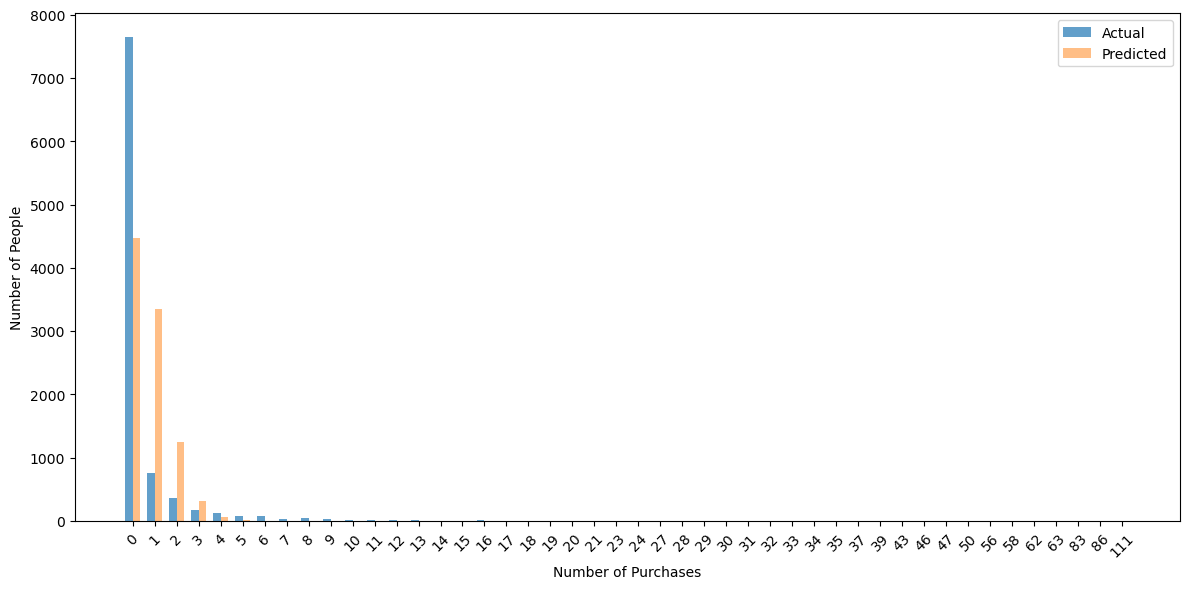

In [102]:
# Plotting the actual and predicted histograms.
bar_width = 0.35
x = range(len(pur))

plt.figure(figsize=(12, 6))  # Increase the figure width to create more space

plt.bar([i - bar_width/2 for i in x], peo, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], preds_2, bar_width, alpha=0.5, label="Predicted", color="tab:orange")

plt.xticks([i for i in x], pur, rotation=45)

plt.xlabel("Number of Purchases")
plt.ylabel("Number of People")
plt.legend()
plt.tight_layout()
plt.show()


### Question 3:  Develop a Poisson model using books02.csv, i.e., by ignoring the independent variables available. Report your code and confirm that the estimated parameters and the maximum value of the log-likelihood are identical to those obtained with the Poisson model developed using books01.csv. Predict the number of people with 0, …, 20, 20+ visits based on the Poisson model. Explain how the predicted values are obtained using the case of 2 exposures (show your calculations). Graph the original and predicted number of visits.

In [103]:
# Setting up the data
b2 = books02.copy()
b2 = b2.drop(['education', 'region', 'hhsz', 'age', 'income', 'child', 'race', 'country', 'domain'], axis=1)
b2

,userid,qty
0,6365661,1
1,6388054,0
2,6396922,1
3,6421559,0
4,6467806,0
...,...,...
9446,15701290,0
9447,15701618,0
9448,15701673,0
9449,15701704,0


In [104]:
# Defining the log-likelihood function
def LL_pb2(params, pur):
    l = params
    prob = []
    ll = []
    purc_a = np.array(books02.qty)
    for i in range(len(purc_a)):
        prob.append(((l**pur[i])*(math.exp(-l)))/math.factorial(pur[i]))
        ll.append(1 * math.log(prob[i]))
    return ll

In [105]:
# Defining the negative log-likelihood function
def NLL_pb2(params, pur):
    return(-np.sum(LL_pb2(params, pur)))

In [106]:
# Setting up the parameters
params = np.array((0.5))
pur = np.array(b2.qty)

In [107]:
# Minimizing the negative log-likelihood to get the estimated parameters
soln_pb2 = minimize(
    NLL_pb2,
    args = (pur),
    x0 = params,
    bounds = [(0.000001, None)],
    tol = 1e-10,
    options = {'ftol' : 1e-8}
)

In [108]:
# Looking into the solution
soln_pb2

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 18921.918429433368
        x: [ 7.485e-01]
      nit: 5
      jac: [ 0.000e+00]
     nfev: 14
     njev: 7
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [109]:
# Getting the value of lambda in this case
lb2 = soln_pb2.x[0]
lb2

0.7484922155186616

In [110]:
# Maximum value of log-likelihood 
mlp_2 = -soln_pb2.fun
mlp_2

-18921.918429433368

In [111]:
# case of 2 exposures calculations
purchases_uid = b2.groupby('userid')['qty'].sum()
purchases_uid

userid
6365661     1
6388054     0
6396922     1
6421559     0
6467806     0
           ..
15701290    0
15701618    0
15701673    0
15701704    0
15702107    0
Name: qty, Length: 9451, dtype: int64

In [112]:
# Taking the qty values separately.
t = purchases_uid.values
t

array([1, 0, 1, ..., 0, 0, 0])

In [113]:
# Setting up the dataframe to fit the Poisson Model accordingly.
b2_p = purchases_uid.value_counts().reset_index()
b2_p.columns = ['QUANTITY', 'CustomerCount']

In [114]:
# Sorting the values in ascending order of QUANTITY
b2_p = b2_p.sort_values(by='QUANTITY')
b2_p

,QUANTITY,CustomerCount
0,0,7639
1,1,753
2,2,362
3,3,175
4,4,126
5,5,82
6,6,74
9,7,30
7,8,48
8,9,31


In [115]:
# Taking the count of people for each exposure case in an array
pe = np.array(b2_p.CustomerCount)
pe

array([7639,  753,  362,  175,  126,   82,   74,   30,   48,   31,   20,
         12,   12,   11,    3,    6,    8,    4,    1,    5,    3,    6,
          3,    1,    3,    5,    2,    3,    1,    1,    1,    3,    1,
          2,    2,    2,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1])

In [116]:
# Taking the QUANTITY or number of purchases in an array
q = np.array(b2_p.QUANTITY)
q

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  23,  24,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  37,  39,  43,  46,  47,  50,
        56,  58,  62,  63,  83,  86, 111])

In [117]:
# Defining the predict function
def predict_p2(op_l, purc, people):
    predP = []
    for i in range(len(purc)):
        pred = ((math.exp(-op_l) * (op_l ** i)) / math.factorial(i)) * people
        predP.append(pred)
    return predP

In [118]:
# Getting the predicted number of people
preds_3 = predict_p2(lb2, q, np.sum(pe))
preds_3

[4471.072624126657,
 3346.563054177397,
 1252.4381973970696,
 312.4800803899772,
 58.47222691913588,
 8.753201334602787,
 1.0919505099696245,
 0.1167594937776995,
 0.010924196522563462,
 0.0009085195619927537,
 6.800198197980003e-05,
 4.627177650156421e-06,
 2.886172042470012e-07,
 1.661751774181846e-08,
 8.884344764995976e-10,
 4.433241931055641e-11,
 2.0739044218162917e-12,
 9.131184208583678e-14,
 3.797011276995451e-15,
 1.4958070437198254e-16,
 5.5979996407113584e-18,
 1.9952662635946265e-19,
 6.788369391761746e-21,
 2.2091485416516604e-22,
 6.889710359794466e-24,
 2.0627578285937736e-25,
 5.938300681548529e-27,
 1.6462117902030507e-28,
 4.400631107364369e-30,
 1.1358062507694822e-31,
 2.833807123461314e-33,
 6.842201845781047e-35,
 1.6004171308045415e-36,
 3.6299992848179116e-38,
 7.991253550072103e-40,
 1.7089688784185254e-41,
 3.5531941723886797e-43,
 7.187941022322161e-45,
 1.4158205002145761e-46,
 2.7172580076470453e-48,
 5.084616165698903e-50,
 9.28242833884384e-52,
 1.654244

In [119]:
# Dividing the predictions by total numbe rof people to get the probability values
only_pred =np.array(preds_3)
only_pred = only_pred/9451
only_pred

array([4.73079317e-01, 3.54096186e-01, 1.32519119e-01, 3.30631764e-02,
       6.18688254e-03, 9.26166684e-04, 1.15538092e-04, 1.23541947e-05,
       1.15587732e-06, 9.61294638e-08, 7.19521553e-09, 4.89596619e-10,
       3.05382715e-11, 1.75828142e-12, 9.40042828e-14, 4.69076493e-15,
       2.19437564e-16, 9.66160640e-18, 4.01757621e-19, 1.58269712e-20,
       5.92318235e-22, 2.11116947e-23, 7.18269960e-25, 2.33747597e-26,
       7.28992737e-28, 2.18258156e-29, 6.28325117e-31, 1.74183874e-32,
       4.65625977e-34, 1.20178420e-35, 2.99842040e-37, 7.23965913e-39,
       1.69338391e-40, 3.84086264e-42, 8.45545821e-44, 1.80824133e-45,
       3.75959599e-47, 7.60548198e-49, 1.49806423e-50, 2.87510106e-52,
       5.37997690e-54, 9.82163616e-56, 1.75033767e-57, 3.04677702e-59,
       5.18292928e-61, 8.62084938e-63])

In [120]:
# Printing predictions for 0 to 20 exposures.
print(only_pred[0:21])

[4.73079317e-01 3.54096186e-01 1.32519119e-01 3.30631764e-02
 6.18688254e-03 9.26166684e-04 1.15538092e-04 1.23541947e-05
 1.15587732e-06 9.61294638e-08 7.19521553e-09 4.89596619e-10
 3.05382715e-11 1.75828142e-12 9.40042828e-14 4.69076493e-15
 2.19437564e-16 9.66160640e-18 4.01757621e-19 1.58269712e-20
 5.92318235e-22]


In [121]:
# Taking sum of 20+ exposure predctions
pred_20 = np.sum(only_pred[22:])
pred_20

7.423961844787368e-25

In [122]:
# Taking the first 10 predictions separately for the ease of plotting graph
p_9 = preds_3[0:10]
p_9

[4471.072624126657,
 3346.563054177397,
 1252.4381973970696,
 312.4800803899772,
 58.47222691913588,
 8.753201334602787,
 1.0919505099696245,
 0.1167594937776995,
 0.010924196522563462,
 0.0009085195619927537]

In [123]:
# Converting the above values into integers
p_9 = np.array(p_9)
p_9 = p_9.astype(int)
p_9

array([4471, 3346, 1252,  312,   58,    8,    1,    0,    0,    0])

In [124]:
# Looking at the integer value of sum of 10 or more exposure case predictions
sum_10_plus = np.sum(preds_3[10:])
sum_10_plus
sum_10_ = sum_10_plus.astype(int)
sum_10_

0

In [125]:
# Appending the 10+ exposure case to the main array
p_9 = np.concatenate((p_9, [sum_10_]))

# Print the array
print(p_9)

[4471 3346 1252  312   58    8    1    0    0    0    0]


In [126]:
# Totaling the people for 10+ exposure case
sum_p_10 = np.sum(pe[10:])

In [127]:
# Looking at the main people array
n_p = np.array(pe[0:10])
n_p

array([7639,  753,  362,  175,  126,   82,   74,   30,   48,   31])

In [128]:
# Appending the 10+ exposure case people count to the main people array
n_p_new = np.append(n_p, sum_p_10)

print(n_p_new)

[7639  753  362  175  126   82   74   30   48   31  131]


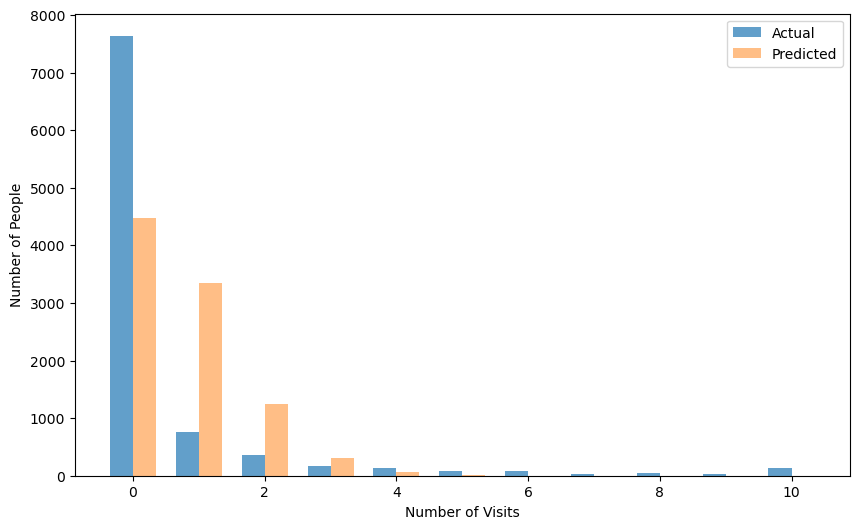

In [129]:
# Plotting the actual vs the predicted data.
bar_width = 0.35
x = range(0, 11)

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], n_p_new, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], p_9, bar_width, alpha=0.5, label="Predicted", color="tab:orange")
plt.xlabel("Number of Visits")
plt.ylabel("Number of People")

plt.legend()
plt.show()

### Question 4: Develop an NBD model using books01.csv. Report your code, the estimated parameters and the maximum value of the log-likelihood (and any other information you believe is relevant).

In [130]:
# Defining the recursive nbd function
def nbd(k, n, a, pmf_k_minus_1):
    return (n + k - 1) / (k * (a + 1)) * pmf_k_minus_1

In [131]:
# Defining the log-likelihood function
def LL_nbd(params, pur, peo):
    n, a = params
    pmf = np.zeros(len(pur))
    pmf[0] = (a / (a + 1)) ** n
    ll_nbd = peo[0] * np.log(pmf[0])
    
    for k in range(1, len(pur)):
        pmf[k] = nbd(k, n, a, pmf[k - 1])
        ll_nbd += peo[k] * np.log(pmf[k])
    
    return -ll_nbd

In [132]:
# Passing the parameters
params = np.array([1.0, 0.5])
pur = np.array(books01.PURCHASES)
peo = np.array(books01.PEOPLE)

In [133]:
# Minimizing the negative log-likelihood value as returend by the LL() function.
soln_nbd = minimize(
    LL_nbd,
    args=(pur, peo),
    x0=params,
    bounds=[(0.000001, None), (0.000001, None)],  # 'r' and 'a' should be >= 0
    tol=1e-10,
    options={'ftol': 1e-8}
)

In [134]:
# Looking into the solution
soln_nbd

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 8329.449038385643
        x: [ 1.014e-01  1.426e-01]
      nit: 15
      jac: [ 4.566e-02 -2.001e-02]
     nfev: 81
     njev: 27
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [135]:
# Printing the optimal n and a values
optimal_n, optimal_a = soln_nbd.x
print(f"Optimal n: {optimal_n}")
print(f"Optimal a: {optimal_a}")

Optimal n: 0.10138854653491085
Optimal a: 0.14261347105530242


In [136]:
# Seeing the maximum value of log-likelihood.
ll_nbd2 = -soln_nbd.fun
ll_nbd2

-8329.449038385643

In [137]:
# Predicting number of people against given number of purchases.
def predict_nbd2(params, pur, total_people):
    n, a = params
    predictions = np.zeros(len(pur))
    predictions[0] = (a / (a + 1)) ** n
    
    for k in range(1, len(pur)):
        predictions[k] = nbd(k, n, a, predictions[k - 1])
    
    # Scale the predictions to the total number of people
    scaled_predictions = predictions * total_people
    
    return scaled_predictions

# Total number of people in the dataset
total_people = np.sum(peo)

# Use the fitted parameters to make predictions and scale them to total people
optimal_params = (optimal_n, optimal_a)
predicted_people = predict_nbd2(optimal_params, pur, total_people)

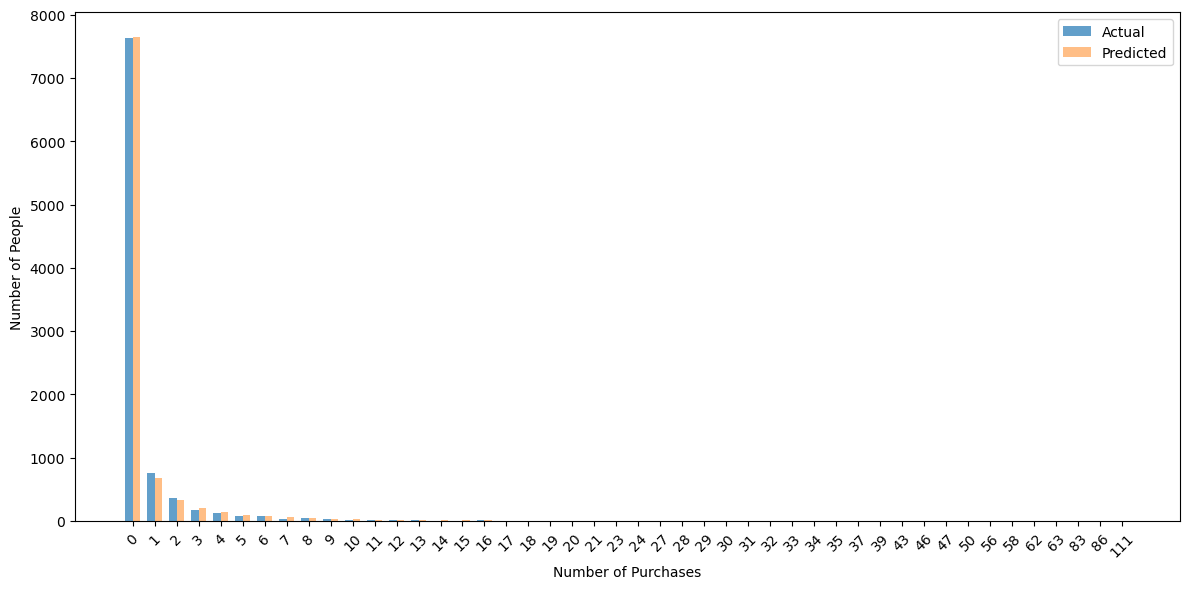

In [138]:
# Plotting Actual vs Predicted number of people against the number of purchases.
bar_width = 0.35
x = range(len(pur))

plt.figure(figsize=(12, 6))  # Increase the figure width to create more space

plt.bar([i - bar_width/2 for i in x], peo, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], predicted_people, bar_width, alpha=0.5, label="Predicted", color="tab:orange")

plt.xticks([i for i in x], pur, rotation=45)

plt.xlabel("Number of Purchases")
plt.ylabel("Number of People")
plt.legend()
plt.tight_layout()
plt.show()

### Question 5: Develop an NBD model using books02.csv (again, ignoring the variables available). Report your code, and confirm that the estimated parameters and the maximum value of the log-likelihood are identical to those obtained with the NBD model developed using books01.csv. Predict the number of people with 0, …, 20, 20+ visits based on the NBD model. Explain how the predicted values are obtained using the case of 2 exposures (show your calculations). Graph the original and predicted number of visits.

In [139]:
# Grouping the purchases by user id.
purchases_userid = books02.groupby('userid')['qty'].sum()
purchases_userid

userid
6365661     1
6388054     0
6396922     1
6421559     0
6467806     0
           ..
15701290    0
15701618    0
15701673    0
15701704    0
15702107    0
Name: qty, Length: 9451, dtype: int64

In [140]:
# Looking into the purchase values
total = purchases_userid.values
total

array([1, 0, 1, ..., 0, 0, 0])

In [141]:
# Taking in the unique values in the purchases array.
uni = np.unique(total)
uni

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  23,  24,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  37,  39,  43,  46,  47,  50,
        56,  58,  62,  63,  83,  86, 111])

In [142]:
# Setting up the dataset for the NBD model application
bn2 = purchases_userid.value_counts().reset_index()
bn2.columns = ['QUANTITY', 'CustomerCount']

In [143]:
# Sorting by quantity in ascending order.
bn2 = bn2.sort_values(by='QUANTITY')
bn2

,QUANTITY,CustomerCount
0,0,7639
1,1,753
2,2,362
3,3,175
4,4,126
5,5,82
6,6,74
9,7,30
7,8,48
8,9,31


In [144]:
# Defining the recursive function
def nbd_b2(k, n, a, pmf_k_minus_1):
    return (n + k - 1) / (k * (a + 1)) * pmf_k_minus_1

In [145]:
# Defining the log-likelihood function
def LL_nbd_b2(params, qt, cus):
    n, a = params
    pmf = np.zeros(len(qt))
    pmf[0] = (a / (a + 1)) ** n
    ll_nbd = cus[0] * np.log(pmf[0])
    
    for k in range(1, len(qt)):
        pmf[k] = nbd_b2(k, n, a, pmf[k - 1])
        ll_nbd += cus[k] * np.log(pmf[k])
    
    return -ll_nbd

In [146]:
# Passing the parameters
params = np.array([1.0, 0.5])
qt = np.array(bn2.QUANTITY)
cus = np.array(bn2.CustomerCount)

In [147]:
# Minimizing the negative log-likelihood value as returend by the LL() function.
soln_nbd_b2 = minimize(
    LL_nbd_b2,
    args=(qt, cus),
    x0=params,
    bounds=[(0.000001, None), (0.000001, None)],  # 'r' and 'a' should be >= 0
    tol=1e-10,
    options={'ftol': 1e-8}
)

In [148]:
# Looking into the solution.
soln_nbd_b2

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 8329.449038385643
        x: [ 1.014e-01  1.426e-01]
      nit: 15
      jac: [ 4.566e-02 -2.001e-02]
     nfev: 81
     njev: 27
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [149]:
# Printing the optimal n and a values
optimal_n_b2, optimal_a_b2 = soln_nbd_b2.x
print(f"Optimal n: {optimal_n_b2}")
print(f"Optimal a: {optimal_a_b2}")

Optimal n: 0.10138854653491085
Optimal a: 0.14261347105530242


In [150]:
# Seeing the maximum value of log-likelihood.
ll_nbd_b2 = -soln_nbd_b2.fun
ll_nbd_b2

-8329.449038385643

In [151]:
# Predict 0 to 20+ and graph + case of 2 exposures calculations
def predict_nbd2(params, pur, total_people):
    n, a = params
    predictions = np.zeros(len(pur))
    predictions[0] = (a / (a + 1)) ** n
    
    for k in range(1, len(pur)):
        predictions[k] = nbd(k, n, a, predictions[k - 1])
    
    # Scale the predictions to the total number of people
    scaled_predictions = predictions * total_people
    
    return scaled_predictions

# Total number of people in the dataset
total_people = np.sum(peo)

# Using the fitted parameters to make predictions and scale them to total people
optimal_params = (optimal_n, optimal_a)
predicted_people = predict_nbd2(optimal_params, pur, total_people)


In [152]:
# Seeing the predicted probabilities
predicted_pro = predicted_people/9451
predicted_pro

array([8.09787815e-01, 7.18556289e-02, 3.46315568e-02, 2.12303807e-02,
       1.44063721e-02, 1.03422778e-02, 7.69580423e-03, 5.87063817e-03,
       4.56078146e-03, 3.59299716e-03, 2.86197074e-03, 2.30013984e-03,
       1.86230564e-03, 1.51720223e-03, 1.24260593e-03, 1.02236201e-03,
       8.44505071e-04, 7.00031093e-04, 5.82072203e-04, 4.85328516e-04,
       4.05668618e-04, 3.39843397e-04, 2.85277717e-04, 2.39916564e-04,
       2.02109969e-04, 1.70525940e-04, 1.44083918e-04, 1.21903456e-04,
       1.03264296e-04, 8.75750978e-05, 7.43487631e-05, 6.31828546e-05,
       5.37439651e-05, 4.57551773e-05, 3.89859569e-05, 3.32439696e-05,
       2.83684320e-05, 2.42246870e-05, 2.06997644e-05, 1.76987363e-05,
       1.51417164e-05, 1.29613823e-05, 1.11009254e-05, 9.51234972e-06,
       8.15505799e-06, 6.99467377e-06])

In [153]:
# Showing the probabilities in case of 0 to 20 exposures:
print(predicted_pro[0:21])

[8.09787815e-01 7.18556289e-02 3.46315568e-02 2.12303807e-02
 1.44063721e-02 1.03422778e-02 7.69580423e-03 5.87063817e-03
 4.56078146e-03 3.59299716e-03 2.86197074e-03 2.30013984e-03
 1.86230564e-03 1.51720223e-03 1.24260593e-03 1.02236201e-03
 8.44505071e-04 7.00031093e-04 5.82072203e-04 4.85328516e-04
 4.05668618e-04]


In [154]:
# Showing probability of 20+ exposures.
# Taking sum of 20+ exposure predctions
pred_20_n = np.sum(predicted_pro[22:])
pred_20_n

0.0018187753702388987

In [155]:
# Setting up the data in a concise way for the purpose of plotting the graph
predicted_people_10 = predicted_people[0:10]
predicted_people_10 = predicted_people_10.astype(int)
predicted_people_10

array([7653,  679,  327,  200,  136,   97,   72,   55,   43,   33])

In [156]:
# Setting up the data in a concise way for the purpose of plotting the graph
predicted_above10 = np.sum(predicted_people[10:])
int(predicted_above10)

151

In [157]:
# Predicted count of people.
predicted_people_10 = np.array([7653,  679,  327,  200,  136,   97,   72,   55,   43,   33])
predicted_people_10 = np.append(predicted_people_10, int(predicted_above10))
predicted_people_10

array([7653,  679,  327,  200,  136,   97,   72,   55,   43,   33,  151])

In [158]:
# Actual count of people.
print(n_p_new)

[7639  753  362  175  126   82   74   30   48   31  131]


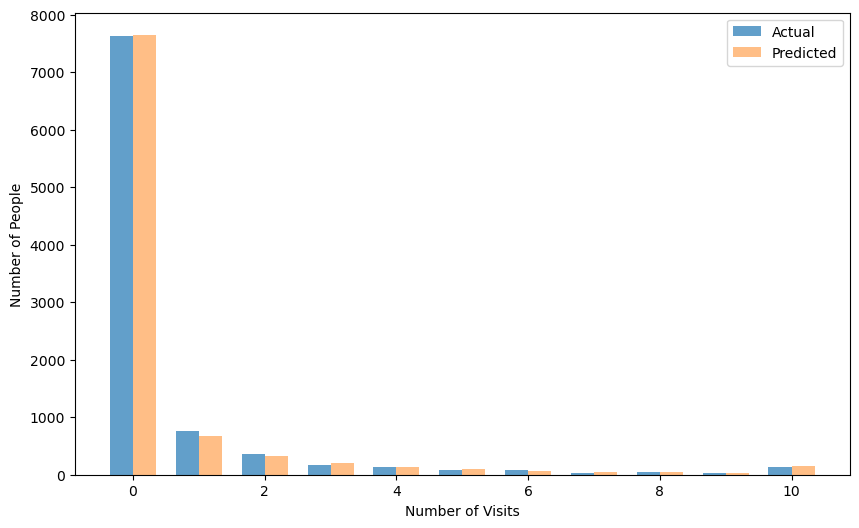

In [159]:
# Plotting the actual vs the predicted data.
bar_width = 0.35
x = range(0, 11)

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], n_p_new, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], predicted_people_10, bar_width, alpha=0.5, label="Predicted", color="tab:orange")
plt.xlabel("Number of Visits")
plt.ylabel("Number of People")

plt.legend()
plt.show()

### Question 6: Calculate the values of (i) reach, (ii) average frequency, and (iii) gross ratings points (GRPs) based on the NBD model. Show your work. 

In [160]:
# Reach based on NBD model
ban_1 = (1-((optimal_a_b2/(optimal_a_b2+1))**optimal_n_b2))*9451
ban_1

reach = (ban_1/9451)*100
reach

19.021218485180334

In [161]:
# Average Frequency
avg_freq = ((optimal_n_b2/optimal_a_b2)*9451)/ban_1
avg_freq

3.7375758322821944

In [162]:
# Gross Rating Points
grps= reach*avg_freq
grps

71.09324651076935

### Question 7: Identify all independent variables with missing values. How many values are missing in each? Drop any variable with many missing values (specify how you are defining “many”). If the number of missing values are very few (again, specify how you are defining “few”), delete the rows involved. For the remaining variables (if any), replace the missing values with the means of the corresponding variables. Explain the steps taken; report your code. 

In [163]:
# Looking into the null value summary in books02.csv
missing_values_count = books02.isnull().sum()
missing_values_count

userid          0
education    6914
region         11
hhsz            0
age             1
income          0
child           0
race            0
country         0
domain          0
qty             0
dtype: int64

In [164]:
# Dropping the education column
books_02 = books02.drop(['education'], axis = 1)
books_02

,userid,region,hhsz,age,income,child,race,country,domain,qty
0,6365661,1.0,2,11.0,7,0,1,0,barnesandnoble.com,1
1,6388054,4.0,1,6.0,5,0,1,0,amazon.com,0
2,6396922,2.0,2,8.0,4,0,1,0,barnesandnoble.com,1
3,6421559,4.0,4,5.0,6,0,1,0,amazon.com,0
4,6467806,2.0,2,6.0,3,0,1,0,amazon.com,0
...,...,...,...,...,...,...,...,...,...,...
9446,15701290,1.0,2,3.0,3,0,1,0,amazon.com,0
9447,15701618,2.0,3,7.0,2,0,1,0,amazon.com,0
9448,15701673,4.0,5,5.0,3,1,1,1,amazon.com,0
9449,15701704,3.0,3,5.0,7,1,1,0,amazon.com,0


In [165]:
# Deleting the rows with empty region values
books_02 = books_02.dropna(subset=['region'])
books_02

,userid,region,hhsz,age,income,child,race,country,domain,qty
0,6365661,1.0,2,11.0,7,0,1,0,barnesandnoble.com,1
1,6388054,4.0,1,6.0,5,0,1,0,amazon.com,0
2,6396922,2.0,2,8.0,4,0,1,0,barnesandnoble.com,1
3,6421559,4.0,4,5.0,6,0,1,0,amazon.com,0
4,6467806,2.0,2,6.0,3,0,1,0,amazon.com,0
...,...,...,...,...,...,...,...,...,...,...
9446,15701290,1.0,2,3.0,3,0,1,0,amazon.com,0
9447,15701618,2.0,3,7.0,2,0,1,0,amazon.com,0
9448,15701673,4.0,5,5.0,3,1,1,1,amazon.com,0
9449,15701704,3.0,3,5.0,7,1,1,0,amazon.com,0


In [166]:
# Deleting the rows with empty age values
books_02 = books_02.dropna(subset=['age'])
books_02

,userid,region,hhsz,age,income,child,race,country,domain,qty
0,6365661,1.0,2,11.0,7,0,1,0,barnesandnoble.com,1
1,6388054,4.0,1,6.0,5,0,1,0,amazon.com,0
2,6396922,2.0,2,8.0,4,0,1,0,barnesandnoble.com,1
3,6421559,4.0,4,5.0,6,0,1,0,amazon.com,0
4,6467806,2.0,2,6.0,3,0,1,0,amazon.com,0
...,...,...,...,...,...,...,...,...,...,...
9446,15701290,1.0,2,3.0,3,0,1,0,amazon.com,0
9447,15701618,2.0,3,7.0,2,0,1,0,amazon.com,0
9448,15701673,4.0,5,5.0,3,1,1,1,amazon.com,0
9449,15701704,3.0,3,5.0,7,1,1,0,amazon.com,0


In [167]:
# Looking into the null value summary in the cleaned books02.csv
missing_values = books_02.isnull().sum()
missing_values

userid     0
region     0
hhsz       0
age        0
income     0
child      0
race       0
country    0
domain     0
qty        0
dtype: int64

### Question 8: Incorporate all the available customer characteristics and estimate all relevant parameters for Poisson regression using MLE. Report your code, the estimated parameters and the maximum value of the log-likelihood (and any other information you believe is relevant). What are the managerial takeaways – which customer characteristics seem to be important? Predict the number of people with 0, …, 20, 20+ visits based on the Poisson regression. Explain how the predicted values are obtained using the case of 2 exposures (show your calculations). Graph the original and predicted number of visits. 

In [168]:
# Dropping the domain column from books_02
books_02 = books_02.drop(['domain'], axis = 1)
books_02

,userid,region,hhsz,age,income,child,race,country,qty
0,6365661,1.0,2,11.0,7,0,1,0,1
1,6388054,4.0,1,6.0,5,0,1,0,0
2,6396922,2.0,2,8.0,4,0,1,0,1
3,6421559,4.0,4,5.0,6,0,1,0,0
4,6467806,2.0,2,6.0,3,0,1,0,0
...,...,...,...,...,...,...,...,...,...
9446,15701290,1.0,2,3.0,3,0,1,0,0
9447,15701618,2.0,3,7.0,2,0,1,0,0
9448,15701673,4.0,5,5.0,3,1,1,1,0
9449,15701704,3.0,3,5.0,7,1,1,0,0


In [169]:
# Defining the log-likelihood function
def LL_pr(params, v, x1, x2, x3, x4, x5, x6, x7):
    l0, b1, b2, b3, b4, b5, b6, b7 = params
    li = []
    for i in range(len(v)):
        li.append(l0*np.exp(b1*x1[i] + b2*x2[i] + b3*x3[i] + b4*x4[i] + b5*x5[i] + b6*x6[i] + b7*x7[i]))
       
    #prob_pr = []
    ll = []
    
    for i in range(len(v)):
            ll_1 = v[i]*np.log(li[i])
            ll_2 = (li[i])
            ll_3a = np.math.factorial(v[i])
            ll_3 = np.log(float(ll_3a))
            ll.append(ll_1-ll_2-ll_3)

    return ll


In [170]:
# Defining the negative log-likelihood function
def NLL_pr(params, v, x1, x2, x3, x4, x5, x6, x7):
    return(-np.sum(LL_pr(params, v, x1, x2, x3, x4, x5, x6, x7)))

In [171]:
# Setting up the parameters
params = np.array([0.5, 0.1, 0.2, 0.5, -0.3, -0.4, 0.3, -0.6])
v = np.array(books_02.qty)
x1 = np.array(books_02.region)
x2 = np.array(books_02.hhsz)
x3 = np.array(books_02.age)
x4 = np.array(books_02.income)
x5 = np.array(books_02.child)
x6 = np.array(books_02.race)
x7 = np.array(books_02.country)

In [172]:
# Minimizing the Negative Log-Likelihood of the model established.
soln_pr = minimize(
    NLL_pr, 
    args=(v, x1, x2, x3, x4, x5, x6, x7),
    x0=params,
    bounds=[(0.00000001,None),(None,None),(None,None),(None,None),(None,None), (None,None), (None,None), (None,None)],
    tol=1e-10,
    options={'ftol':1e-8}
)

In [173]:
# Looking into the solution
soln_pr

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18819.04764118097
        x: [ 9.501e-01 -1.023e-01 -1.493e-02  2.512e-02  1.498e-02
             7.274e-02 -2.087e-01 -1.181e-01]
      nit: 36
      jac: [ 1.441e-01 -1.201e-02  7.614e-01  1.314e+00  6.297e-01
             1.783e-02 -6.185e-02 -1.233e-01]
     nfev: 396
     njev: 44
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

In [174]:
# Printing the optimal values of the estimated parameters
optimal_l0, optimal_b1, optimal_b2, optimal_b3, optimal_b4, optimal_b5, optimal_b6, optimal_b7 = soln_pr.x
print(f"Optimal l0: {optimal_l0}")
print(f"Optimal b1: {optimal_b1}")
print(f"Optimal b2: {optimal_b2}")
print(f"Optimal b3: {optimal_b3}")
print(f"Optimal b4: {optimal_b4}")
print(f"Optimal b5: {optimal_b5}")
print(f"Optimal b6: {optimal_b6}")
print(f"Optimal b7: {optimal_b7}")

Optimal l0: 0.9501381310232119
Optimal b1: -0.10226512358116391
Optimal b2: -0.014932795975360149
Optimal b3: 0.025121516423466078
Optimal b4: 0.014981187604258272
Optimal b5: 0.0727424297563818
Optimal b6: -0.2086595333094896
Optimal b7: -0.11808442249233174


In [175]:
# Printing the maximum value of log-likelihood.
mll_pr2 = -soln_pr.fun
mll_pr2

-18819.04764118097

In [176]:
# Predicting number of people aginst number of visits using the Poisson Regression
def pred_pr2(v, x1, x2, x3, x4, x5, x6, x7):
    predPr = []
    li = []
    for i in range(len(v)):
        li.append(optimal_l0*np.exp(optimal_b1*x1[i] + optimal_b2*x2[i] + optimal_b3*x3[i] + optimal_b4*x4[i] + optimal_b5*x5[i] + optimal_b6*x6[i] + optimal_b7*x7[i]))
        
    for j in range(len(v)):
        pred = ((math.exp(-li[j]) * (li[j] ** v[j])) / math.factorial(v[j]))
        predPr.append(pred)
    return predPr

In [177]:
# Setting up the parameters
v = np.array(books_02.qty)
x1 = np.array(books_02.region)
x2 = np.array(books_02.hhsz)
x3 = np.array(books_02.age)
x4 = np.array(books_02.income)
x5 = np.array(books_02.child)
x6 = np.array(books_02.race)
x7 = np.array(books_02.country)

In [178]:
# getting the predicted values.
preds_2 = pred_pr2(v, x1, x2, x3, x4, x5, x6, x7)

In [179]:
preds_2[9438]

0.4867483739556006

In [180]:
# Setting up the dataset for easy calculation of predictions and also for plotting the graph.
pred_ban = books_02.copy()
pred_ban

,userid,region,hhsz,age,income,child,race,country,qty
0,6365661,1.0,2,11.0,7,0,1,0,1
1,6388054,4.0,1,6.0,5,0,1,0,0
2,6396922,2.0,2,8.0,4,0,1,0,1
3,6421559,4.0,4,5.0,6,0,1,0,0
4,6467806,2.0,2,6.0,3,0,1,0,0
...,...,...,...,...,...,...,...,...,...
9446,15701290,1.0,2,3.0,3,0,1,0,0
9447,15701618,2.0,3,7.0,2,0,1,0,0
9448,15701673,4.0,5,5.0,3,1,1,1,0
9449,15701704,3.0,3,5.0,7,1,1,0,0


In [181]:
pred_ban = pred_ban.reset_index(drop=True)
pred_ban

,userid,region,hhsz,age,income,child,race,country,qty
0,6365661,1.0,2,11.0,7,0,1,0,1
1,6388054,4.0,1,6.0,5,0,1,0,0
2,6396922,2.0,2,8.0,4,0,1,0,1
3,6421559,4.0,4,5.0,6,0,1,0,0
4,6467806,2.0,2,6.0,3,0,1,0,0
...,...,...,...,...,...,...,...,...,...
9434,15701290,1.0,2,3.0,3,0,1,0,0
9435,15701618,2.0,3,7.0,2,0,1,0,0
9436,15701673,4.0,5,5.0,3,1,1,1,0
9437,15701704,3.0,3,5.0,7,1,1,0,0


In [182]:
# Creating a Pandas Series from the list `preds`.
preds_series2 = pd.Series(preds_2, name='preds')

# Inserting the Pandas Series into the DataFrame `pred_kch` as a new column.
pred_ban.insert(loc=len(pred_ban.columns), column='preds', value=preds_series2)


In [183]:
pred_ban

,userid,region,hhsz,age,income,child,race,country,qty,preds
0,6365661,1.0,2,11.0,7,0,1,0,1,0.367858
1,6388054,4.0,1,6.0,5,0,1,0,0,0.531292
2,6396922,2.0,2,8.0,4,0,1,0,1,0.358719
3,6421559,4.0,4,5.0,6,0,1,0,0,0.549562
4,6467806,2.0,2,6.0,3,0,1,0,0,0.476205
...,...,...,...,...,...,...,...,...,...,...
9434,15701290,1.0,2,3.0,3,0,1,0,0,0.466668
9435,15701618,2.0,3,7.0,2,0,1,0,0,0.477897
9436,15701673,4.0,5,5.0,3,1,1,1,0,0.583420
9437,15701704,3.0,3,5.0,7,1,1,0,0,0.479611


In [184]:
# Getting the unique visit counts
unique_visits = np.unique(pred_ban['qty'])

# Initializing a dictionary to store the results
results_by_visit = {}

# Looping through each unique visit count
for visit_count in unique_visits:
    indices = np.where(pred_ban['qty'] == visit_count)[0]
    pred_sum = pred_ban.loc[indices, 'preds'].sum()
    results_by_visit[visit_count] = {'pred_sum': pred_sum, 'num_indices': len(indices)}

# Printing the results.
for visit_count, result in results_by_visit.items():
    print(f"Visits: {visit_count}, Predicted Sum: {result['pred_sum']}, Number of People: {result['num_indices']}")


Visits: 0, Predicted Sum: 3642.704857248863, Number of People: 7630
Visits: 1, Predicted Sum: 264.10921388999157, Number of People: 752
Visits: 2, Predicted Sum: 48.906530028396126, Number of People: 362
Visits: 3, Predicted Sum: 5.888695029115134, Number of People: 173
Visits: 4, Predicted Sum: 0.8438349073963672, Number of People: 126
Visits: 5, Predicted Sum: 0.09273590744207509, Number of People: 82
Visits: 6, Predicted Sum: 0.011739439979081912, Number of People: 74
Visits: 7, Predicted Sum: 0.0005199927417558926, Number of People: 30
Visits: 8, Predicted Sum: 0.0001086686460539069, Number of People: 48
Visits: 9, Predicted Sum: 5.274358613238541e-06, Number of People: 31
Visits: 10, Predicted Sum: 4.223285536843104e-07, Number of People: 20
Visits: 11, Predicted Sum: 4.049265369354869e-08, Number of People: 12
Visits: 12, Predicted Sum: 9.679507311594747e-10, Number of People: 12
Visits: 13, Predicted Sum: 1.0993576465119396e-10, Number of People: 11
Visits: 14, Predicted Sum: 3.

In [185]:
# Setting up the values to plot the graph, from the above information.
# Note: The values after 10 visits are very small so to plot the graphs, we will combine the result as 10+ visits.
num_people=[7630, 752, 362, 173, 126, 82, 74, 30, 48, 31, 131]

In [186]:
# Initializing an array to store the calculated values
calculated_values = np.zeros(len(results_by_visit))

# Looping through each unique visit count
for i, (visit_count, result) in enumerate(results_by_visit.items()):
    calculated_values[i] = (result['pred_sum'] / result['num_indices']) * 9439

In [187]:
# Getting the sum of probabilities for 10+ visits.
sum_10_plus = np.sum(calculated_values[10:])
sum_10_plus

0.00023202587921040667

In [188]:
calculated_values

array([4.50635533e+003, 3.31506233e+003, 1.27521751e+003, 3.21291285e+002,
       6.32139499e+001, 1.06748077e+001, 1.49741316e+000, 1.63607050e-001,
       2.13692365e-002, 1.60595713e-003, 1.99317961e-004, 3.18508465e-005,
       7.61373913e-007, 9.43348802e-008, 1.24950875e-009, 7.68460477e-011,
       3.51719525e-011, 1.45960891e-012, 1.73179094e-015, 1.72633206e-016,
       2.00778658e-016, 1.80436506e-018, 3.00860925e-020, 5.06906797e-024,
       1.44448694e-025, 1.21023869e-030, 3.37496080e-030, 1.67030191e-030,
       3.65849556e-033, 5.75922056e-038, 2.77010496e-035, 4.04321218e-040,
       9.98569512e-037, 6.61807299e-043, 5.99803037e-048, 2.00712017e-052,
       1.34948665e-058, 5.76683924e-063, 1.34542843e-070, 9.68608437e-084,
       3.22080101e-082, 8.29748934e-090, 1.62412218e-090, 8.64879503e-123,
       1.66727665e-132, 7.77859080e-194])

In [189]:
# Predicting 0 to 20 visits case:
c = np.zeros(len(results_by_visit))
for i, (visit_count, result) in enumerate(results_by_visit.items()):
    c[i] = (result['pred_sum'] / result['num_indices'])
c

array([4.77418723e-001, 3.51209061e-001, 1.35100912e-001, 3.40386996e-002,
       6.69710244e-003, 1.13092570e-003, 1.58641081e-004, 1.73330914e-005,
       2.26393013e-006, 1.70140600e-007, 2.11164277e-008, 3.37438781e-009,
       8.06625609e-011, 9.99416042e-012, 1.32377238e-013, 8.14133359e-015,
       3.72623716e-015, 1.54635969e-016, 1.83471866e-019, 1.82893534e-020,
       2.12711790e-020, 1.91160617e-022, 3.18742372e-024, 5.37034428e-028,
       1.53033896e-029, 1.28216833e-034, 3.57554911e-034, 1.76957508e-034,
       3.87593554e-037, 6.10151559e-042, 2.93474411e-039, 4.28351751e-044,
       1.05791875e-040, 7.01141327e-047, 6.35451887e-052, 2.12641188e-056,
       1.42969239e-062, 6.10958707e-067, 1.42539297e-074, 1.02617696e-087,
       3.41222694e-086, 8.79064450e-094, 1.72065069e-094, 9.16282978e-127,
       1.76637000e-136, 8.24090561e-198])

In [190]:
# Predicting 0 to 20 visits case:
print(c[0:21])

[4.77418723e-01 3.51209061e-01 1.35100912e-01 3.40386996e-02
 6.69710244e-03 1.13092570e-03 1.58641081e-04 1.73330914e-05
 2.26393013e-06 1.70140600e-07 2.11164277e-08 3.37438781e-09
 8.06625609e-11 9.99416042e-12 1.32377238e-13 8.14133359e-15
 3.72623716e-15 1.54635969e-16 1.83471866e-19 1.82893534e-20
 2.12711790e-20]


In [191]:
# Showing probability of 20+ exposures.
# Taking sum of 20+ exposure predctions
pred_20_pr = np.sum(c[22:])
pred_20_pr

3.1879760626455283e-24

In [192]:
# Converting the predicted values into integers for the purpose of plotting the graph.
predicted_people = [4.50635533e+003, 3.31506233e+003, 1.27521751e+003, 3.21291285e+002, 6.32139499e+001, 1.06748077e+001, 1.49741316e+000, 1.63607050e-001, 2.13692365e-002, 1.60595713e-003, 0.00023202587921040667]
predicted_people = [int(x) for x in predicted_people]
predicted_people

[4506, 3315, 1275, 321, 63, 10, 1, 0, 0, 0, 0]

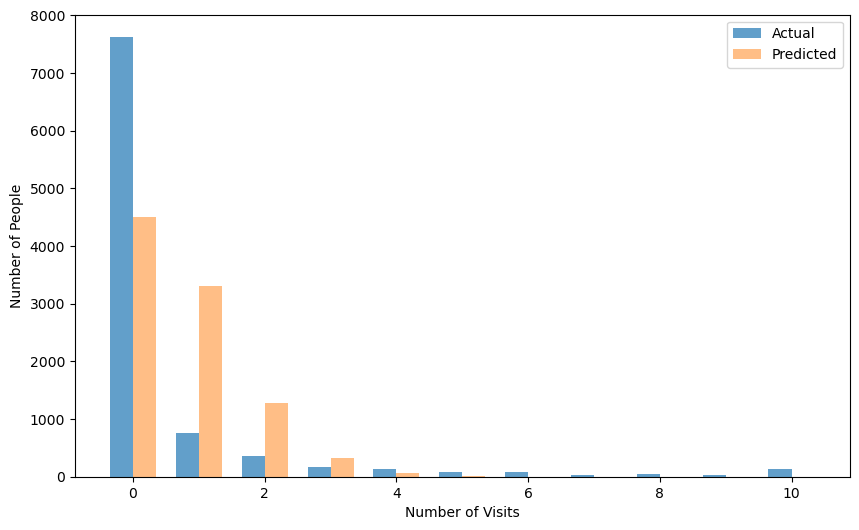

In [193]:
# Plotting the actual vs the predicted data.
bar_width = 0.35
x = range(0, 11)

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], num_people, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], predicted_people, bar_width, alpha=0.5, label="Predicted", color="tab:orange")
plt.xlabel("Number of Visits")
plt.ylabel("Number of People")

plt.legend()
plt.show()


### Question 9: Estimate all relevant parameters for NBD regression using MLE. Report your code, the estimated parameters and the maximum value of the log-likelihood (and any other information you believe is relevant). What are the managerial takeaways – which customer characteristics seem to be important? Predict the number of people with 0, …, 20, 20+ visits based on the NBD regression. Explain how the predicted values are obtained using the case of 2 exposures (show your calculations). Graph the original and predicted number of visits.

In [194]:
books_02

,userid,region,hhsz,age,income,child,race,country,qty
0,6365661,1.0,2,11.0,7,0,1,0,1
1,6388054,4.0,1,6.0,5,0,1,0,0
2,6396922,2.0,2,8.0,4,0,1,0,1
3,6421559,4.0,4,5.0,6,0,1,0,0
4,6467806,2.0,2,6.0,3,0,1,0,0
...,...,...,...,...,...,...,...,...,...
9446,15701290,1.0,2,3.0,3,0,1,0,0
9447,15701618,2.0,3,7.0,2,0,1,0,0
9448,15701673,4.0,5,5.0,3,1,1,1,0
9449,15701704,3.0,3,5.0,7,1,1,0,0


In [195]:
# Setting up the parameters.

y = np.array(books_02.qty)
x1 = np.array(books_02.region)
x2 = np.array(books_02.hhsz)
x3 = np.array(books_02.age)
x4 = np.array(books_02.income)
x5 = np.array(books_02.child)
x6 = np.array(books_02.race)
x7 = np.array(books_02.country)

In [196]:
# Defining the NBD-regression Log Likelihood fucntion

def NBDReg(params,x1,x2,x3,x4,x5, x6, x7, y):
    n,alpha,nbeta1, nbeta2, nbeta3, nbeta4, nbeta5, nbeta6, nbeta7 = params
    nll=0
    nll1=0
    nll2=0
    nll3=0
    nll4=0
    for i in range(len(x1)):
        beta=math.exp(nbeta1*x1[i]+nbeta2*x2[i]+nbeta3*x3[i]+nbeta4*x4[i]+nbeta5*x5[i]+nbeta6*x6[i]+nbeta7*x7[i])
        nll1=nll1+np.log(math.gamma(n+int(y[i])))
        nll2=nll2+np.log(math.gamma(n))+np.log(factorial(int(y[i])))
        nll3=nll3+n*(np.log(alpha)-np.log(alpha+beta))
        nll4=nll4+int(y[i])*(np.log(beta)-np.log(alpha+beta))
    nll=nll1-nll2+nll3+nll4
    return nll*(-1)
    

In [197]:
NBD_result=minimize(NBDReg,  args=(x1,x2,x3,x4,x5,x6,x7,y),x0=np.array((1,1,0.2,0.3,0.1,-0.3, -0.4, 0.3, -0.6)),bounds=[(0.00000001,None),(0.00000001,None),(None,None),(None,None),(None,None),(None,None), (None,None), (None,None), (None,None)],tol=1e-10,options={'ftol':1e-8})
n = NBD_result.x[0]
alpha=NBD_result.x[1]
beta1 = NBD_result.x[2]
beta2 = NBD_result.x[3]
beta3 = NBD_result.x[4]
beta4 = NBD_result.x[5]
beta5 = NBD_result.x[6]
beta6 = NBD_result.x[7]
beta7 = NBD_result.x[8]

In [198]:
nll=0
nll1=0
nll2=0
nll3=0
nll4=0

for i in range(len(x1)):
    beta=math.exp(beta1*x1[i]+beta2*x2[i]+beta3*x3[i]+beta4*x4[i]+beta5*x5[i]+beta6*x6[i]+beta7*x7[i])
    nll1=nll1+np.log(math.gamma(n+int(y[i])))
    nll2=nll2+np.log(math.gamma(n))+np.log(factorial(int(y[i])))
    nll3=nll3+n*(np.log(alpha)-np.log(alpha+beta))
    nll4=nll4+int(y[i])*(np.log(beta)-np.log(alpha+beta))
nll=nll1-nll2+nll3+nll4

In [199]:
# Looking into the solution
NBD_result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 8358.772592724461
        x: [ 9.803e-02  1.077e-01 -1.028e-01 -8.910e-03  2.835e-02
             1.726e-02  5.890e-02 -2.103e-01 -1.009e-01]
      nit: 68
      jac: [-1.320e+00 -6.234e-01  8.129e-01 -1.854e-01 -3.392e-01
             2.346e-02  2.838e-02  3.365e-02  8.404e-02]
     nfev: 790
     njev: 79
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>

In [200]:
print("n: {}".format(n))
print("alpha:{}".format(alpha))
print("beta1: {}".format(beta1))
print("beta2: {}".format(beta2))
print("beta3: {}".format(beta3))
print("beta4: {}".format(beta4))
print("beta5: {}".format(beta5))
print("beta6: {}".format(beta6))
print("beta7: {}".format(beta7))
print("log likelihood: {}".format(nll))

n: 0.09802820907637659
alpha:0.10766164255228315
beta1: -0.1027936523434462
beta2: -0.008910348417223993
beta3: 0.028346584977536064
beta4: 0.017260994432668778
beta5: 0.05889670844033888
beta6: -0.21026488596152973
beta7: -0.10094470188511201
log likelihood: -8358.772592724461


In [201]:
# Predictions 0 to 20 and 20+ plus graph.
# Setting up the predict function
def predict_nbdr2(x1, x2, x3, x4, x5, x6, x7, y):
    predPr = []
    b = []
    for i in range(len(v)):  # This iterates over all elements in the input arrays
        b.append(math.exp(beta1 * x1[i] + beta2 * x2[i] + beta3 * x3[i] + beta4 * x4[i] + beta5 * x5[i] + beta6 * x6[i] + beta7 * x7[i]))

    for j in range(len(v)):
        p_1 = (math.gamma(n + v[j])) / (math.gamma(n) * math.factorial(v[j]))
        p_2 = (alpha / (alpha + b[j])) ** n
        p_3 = (b[j] / (alpha + b[j])) ** v[j]
        pred = p_1 * p_2 * p_3
        predPr.append(pred)

    return predPr


In [202]:
# Setting up the parameters
y = np.array(books_02.qty)
x1 = np.array(books_02.region)
x2 = np.array(books_02.hhsz)
x3 = np.array(books_02.age)
x4 = np.array(books_02.income)
x5 = np.array(books_02.child)
x6 = np.array(books_02.race)
x7 = np.array(books_02.country)

In [203]:
# Getting the predicted values/probabilities
ans2 = predict_nbdr2(x1, x2, x3, x4, x5, x6, x7, y)

In [204]:
# Setting up the dataset for easy calculation of predictions and also for plotting the graph.
pred_nr2 = books_02.copy()
pred_nr2

,userid,region,hhsz,age,income,child,race,country,qty
0,6365661,1.0,2,11.0,7,0,1,0,1
1,6388054,4.0,1,6.0,5,0,1,0,0
2,6396922,2.0,2,8.0,4,0,1,0,1
3,6421559,4.0,4,5.0,6,0,1,0,0
4,6467806,2.0,2,6.0,3,0,1,0,0
...,...,...,...,...,...,...,...,...,...
9446,15701290,1.0,2,3.0,3,0,1,0,0
9447,15701618,2.0,3,7.0,2,0,1,0,0
9448,15701673,4.0,5,5.0,3,1,1,1,0
9449,15701704,3.0,3,5.0,7,1,1,0,0


In [205]:
pred_nr2 = pred_nr2.reset_index(drop=True)
pred_nr2

,userid,region,hhsz,age,income,child,race,country,qty
0,6365661,1.0,2,11.0,7,0,1,0,1
1,6388054,4.0,1,6.0,5,0,1,0,0
2,6396922,2.0,2,8.0,4,0,1,0,1
3,6421559,4.0,4,5.0,6,0,1,0,0
4,6467806,2.0,2,6.0,3,0,1,0,0
...,...,...,...,...,...,...,...,...,...
9434,15701290,1.0,2,3.0,3,0,1,0,0
9435,15701618,2.0,3,7.0,2,0,1,0,0
9436,15701673,4.0,5,5.0,3,1,1,1,0
9437,15701704,3.0,3,5.0,7,1,1,0,0


In [206]:
# Creating a Pandas Series from the list `preds`.
preds_nr_series = pd.Series(ans2, name='preds_nbd')

# Inserting the Pandas Series into the DataFrame `pred_kch` as a new column.
pred_nr2.insert(loc=len(pred_nr2.columns), column='preds_nbd', value=preds_nr_series)


In [207]:
pred_nr2

,userid,region,hhsz,age,income,child,race,country,qty,preds_nbd
0,6365661,1.0,2,11.0,7,0,1,0,1,0.070450
1,6388054,4.0,1,6.0,5,0,1,0,0,0.821951
2,6396922,2.0,2,8.0,4,0,1,0,1,0.070270
3,6421559,4.0,4,5.0,6,0,1,0,0,0.824583
4,6467806,2.0,2,6.0,3,0,1,0,0,0.810613
...,...,...,...,...,...,...,...,...,...,...
9434,15701290,1.0,2,3.0,3,0,1,0,0,0.809368
9435,15701618,2.0,3,7.0,2,0,1,0,0,0.810461
9436,15701673,4.0,5,5.0,3,1,1,1,0,0.831705
9437,15701704,3.0,3,5.0,7,1,1,0,0,0.811463


In [208]:
# Getting the unique visit counts
unique_visits = np.unique(pred_nr2['qty'])

# Initializing a dictionary to store the results
results_by_visit = {}

# Looping through each unique visit count
for visit_count in unique_visits:
    indices = np.where(pred_nr2['qty'] == visit_count)[0]
    pred_sum = pred_nr2.loc[indices, 'preds_nbd'].sum()
    results_by_visit[visit_count] = {'pred_sum': pred_sum, 'num_indices': len(indices)}

# Printing the results.
for visit_count, result in results_by_visit.items():
    print(f"Visits: {visit_count}, Predicted Sum: {result['pred_sum']}, Number of People: {result['num_indices']}")


Visits: 0, Predicted Sum: 6184.901746715645, Number of People: 7630
Visits: 1, Predicted Sum: 52.68660733832411, Number of People: 752
Visits: 2, Predicted Sum: 12.311733732528573, Number of People: 362
Visits: 3, Predicted Sum: 3.624479509401622, Number of People: 173
Visits: 4, Predicted Sum: 1.7999694960116837, Number of People: 126
Visits: 5, Predicted Sum: 0.8460964488195676, Number of People: 82
Visits: 6, Predicted Sum: 0.5818418498508722, Number of People: 74
Visits: 7, Predicted Sum: 0.1796297392253844, Number of People: 30
Visits: 8, Predicted Sum: 0.2330266876706437, Number of People: 48
Visits: 9, Predicted Sum: 0.11814397736685972, Number of People: 31
Visits: 10, Predicted Sum: 0.05952371680084739, Number of People: 20
Visits: 11, Predicted Sum: 0.033309461506678545, Number of People: 12
Visits: 12, Predicted Sum: 0.024491729423754535, Number of People: 12
Visits: 13, Predicted Sum: 0.020214141863537496, Number of People: 11
Visits: 14, Predicted Sum: 0.004225460773292012

In [209]:
# Setting up the values to plot the graph, from the above information.
# Note: The values after 10 visits are very small so to plot the graphs, we will combine the result as 10+ visits.
nbdr_people = [7630, 752, 362, 173, 126, 82, 74, 30, 48, 31, 131]

In [210]:
# Initializing an array to store the calculated values
calculated_values_nbdr = np.zeros(len(results_by_visit))

# Looping through each unique visit count
for i, (visit_count, result) in enumerate(results_by_visit.items()):
    calculated_values_nbdr[i] = (result['pred_sum'] / result['num_indices']) * 9439

In [211]:
# Getting the sum of probabilities for 10+ visits.
sum_10_plus_nbdr = np.sum(calculated_values_nbdr[10:])
sum_10_plus_nbdr

170.70353359183832

In [212]:
# Looking into the predicted probabilities
calculated_values_nbdr

array([7.65128278e+03, 6.61315009e+02, 3.21023356e+02, 1.97754116e+02,
       1.34840572e+02, 9.73939559e+01, 7.42162868e+01, 5.65175036e+01,
       4.58237272e+01, 3.59729356e+01, 2.80922181e+01, 2.62006673e+01,
       1.92647862e+01, 1.73455714e+01, 1.32947081e+01, 9.72817981e+00,
       1.04360096e+01, 9.71526450e+00, 5.75275540e+00, 4.45930214e+00,
       5.67998811e+00, 4.20123455e+00, 3.13273887e+00, 2.23851812e+00,
       1.87601347e+00, 9.48963360e-01, 1.43007816e+00, 1.12694715e+00,
       1.28310237e+00, 4.52465887e-01, 1.17239856e+00, 4.22380593e-01,
       1.29434132e+00, 4.07780676e-01, 1.94303286e-01, 2.56299737e-01,
       1.47986022e-01, 6.90701796e-02, 2.32013052e-02, 5.04985114e-03,
       1.91269061e-02, 1.32415999e-02, 1.24241232e-02, 4.96120505e-03,
       1.44908989e-03, 6.65215066e-06])

In [213]:
# Predicting 0 to 20 visits case:
c_nbd = np.zeros(len(results_by_visit))
for i, (visit_count, result) in enumerate(results_by_visit.items()):
    c_nbd[i] = (result['pred_sum'] / result['num_indices'])
c_nbd

array([8.10603112e-01, 7.00619778e-02, 3.40103142e-02, 2.09507486e-02,
       1.42854722e-02, 1.03182494e-02, 7.86272770e-03, 5.98765797e-03,
       4.85472266e-03, 3.81109604e-03, 2.97618584e-03, 2.77578846e-03,
       2.04097745e-03, 1.83764926e-03, 1.40848692e-03, 1.03063670e-03,
       1.10562661e-03, 1.02926841e-03, 6.09466617e-04, 4.72433747e-04,
       6.01757402e-04, 4.45093182e-04, 3.31893089e-04, 2.37156279e-04,
       1.98751295e-04, 1.00536430e-04, 1.51507380e-04, 1.19392642e-04,
       1.35936262e-04, 4.79357863e-05, 1.24207921e-04, 4.47484472e-05,
       1.37126954e-04, 4.32016819e-05, 2.05851559e-05, 2.71532723e-05,
       1.56781462e-05, 7.31753147e-06, 2.45802577e-06, 5.34998532e-07,
       2.02636996e-06, 1.40286046e-06, 1.31625418e-06, 5.25607061e-07,
       1.53521548e-07, 7.04751633e-10])

In [214]:
# Predicting 0 to 20 visits case:
print(c_nbd[0:21])

[8.10603112e-01 7.00619778e-02 3.40103142e-02 2.09507486e-02
 1.42854722e-02 1.03182494e-02 7.86272770e-03 5.98765797e-03
 4.85472266e-03 3.81109604e-03 2.97618584e-03 2.77578846e-03
 2.04097745e-03 1.83764926e-03 1.40848692e-03 1.03063670e-03
 1.10562661e-03 1.02926841e-03 6.09466617e-04 4.72433747e-04
 6.01757402e-04]


In [215]:
# Showing probability of 20+ exposures.
# Taking sum of 20+ exposure predctions
pred_20_nbdr = np.sum(c_nbd[22:])
pred_20_nbdr

0.0017515466145689722

In [216]:
# Converting the predicted values into integers for easy plotting of the graph
predicted_nreg = [7.65128278e+03, 6.61315009e+02, 3.21023356e+02, 1.97754116e+02, 1.34840572e+02, 9.73939559e+01, 7.42162868e+01, 5.65175036e+01, 4.58237272e+01, 3.59729356e+01, 170.70353359183832]
predicted_nreg = [int(x) for x in predicted_nreg]
predicted_nreg

[7651, 661, 321, 197, 134, 97, 74, 56, 45, 35, 170]

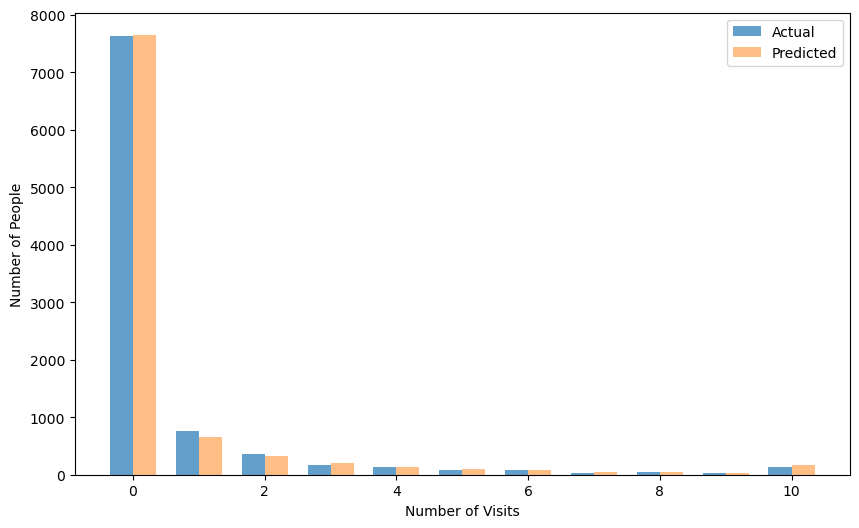

In [217]:
# Plotting the actual vs the predicted data.
bar_width = 0.35
x = range(0, 11)

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], nbdr_people, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], predicted_nreg, bar_width, alpha=0.5, label="Predicted", color="tab:orange")
plt.xlabel("Number of Visits")
plt.ylabel("Number of People")

plt.legend()
plt.show()


### Question 10: Evaluate all the models developed using the log-likelihood ratio, AIC, and BIC. What are your recommendations on which model to use based on each of these criteria? Are the recommendations consistent? Explain why you are recommending the model you have selected. Are there any significant differences among the results from the models? If so, what exactly are these differences? Discuss what you believe could be causing the differences. 

In [218]:
# Calculating AIC, BIC and Log-Likelihood Ratio for Poisson Model.
k = 1
n = 9451
aic_p = (2*k) - 2*(-18921.92)
aic_p

37845.84

In [219]:
bic_p = k*np.log(n) - 2*(-18921.92)
bic_p

37852.99387583499

In [220]:
# Calculating AIC, BIC and Log-Likelihood Ratio for NBD Model.
k = 2
n = 9451
aic_nbd = (2*k) - 2*(-8329.45)
aic_nbd

16662.9

In [221]:
bic_nbd = k*np.log(n) - 2*(-8329.45)
bic_nbd

16677.20775166999

In [222]:
# Calculating AIC, BIC and Log-Likelihood Ratio for Poisson Regression Model.
k = 8
n = 9439
aic_pr = (2*k) - 2*(-18819.05)
aic_pr

37654.1

In [223]:
bic_pr = k*np.log(n) - 2*(-18819.05)
bic_pr

37711.320842570596

In [224]:
# Calculating AIC, BIC and Log-Likelihood Ratio for NBD Regression Model.
k = 9
n = 9439
aic_nbdr = (2*k) - 2*(-8358.77)
aic_nbdr

16735.54

In [225]:
bic_nbdr = k*np.log(n) - 2*(-8358.77)
bic_nbdr

16799.913447891926

In [226]:
# LRT 
# The Poisson Model is nested within Poisson Regression and NBD Regression Model.
# So,we have 2 cases: Case - 1: Do LLR test on Poisson Model and Poisson Regression model.
# Case - 2: Do LRT on Poisson Model and NBD Regression model.
#LRT = 2 * (ln(Lc) - ln(Ls))

# Case-1:Poisson Model (simple) vs Poisson Regression Model (complex)
# LL_PoissonModel = 18921.91842943338
# LL_PoissonRegressionModel = 18819.04764118097

LRT_p_pr = 2 * (18921.91842943338 - (18819.04764118097))
LRT_p_pr

205.74157650482084

In [227]:
# Case-2:Poisson Model (simple) vs NBD Regression Model (complex)
# LL_PoissonModel = -18921.91842943338
# LL_NBDRegressionModel = -8358.772592724461

LRT_p_nbdr = 2 * (18921.91842943338 - (8358.772592724461))
LRT_p_nbdr

21126.291673417836

In [228]:
# The NBD Model is nested within the NBD Regression Model
# So we do the LRT on this scenario:
# NBD Model (simple) vs NBD Regression Model (complex)
# LL_NBDModel = 8329.449038385643
# LL_NBDRegressionModel = 8358.772592724461

LRT_nbd_nbdr = 2 * (8329.449038385643 - (8358.772592724461))
LRT_nbd_nbdr

-58.647108677636425